In [123]:
from importlib import reload
import sys
sys.path += ["/home/jacopo.lenti/Projects/learning-od-step-by-step/src"]
import opinion_dynamics_models_estimation as oe
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import pandas as pd
from tqdm import tqdm
import numpy as np
import repeat_function
from torcheval.metrics.functional import r2_score

In [124]:
reload(oe)

<module 'opinion_dynamics_models_estimation' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/src/opinion_dynamics_models_estimation.py'>

In [3]:
N,T,edge_per_t = 200, 100, 8

model_name = "simple_BC"

evidences_per_t = 16

optimizer_name = "SGD"

lr, num_epochs = 0.0005, 800   
epsilon0 = 0.25
epsilon, mu, rho = parameters = 0.09, 0.23, 16
hide_progress = False
minibatch_size = 32

patience, min_delta, min_epochs, sample_pairs = 20, 1e-6, 20, 50

In [10]:
X, edges, evidences = oe.simulate_BC(N, T, edge_per_t, 10, (epsilon, mu, rho))

In [11]:
history = oe.estimation_BC_model_from_data(X, edges, evidences, parameters,
                                           epsilon0, "BC_with_evidence",optimizer_name,
                                           lr, num_epochs, hide_progress, patience, min_delta,
                                           minibatch_size, min_epochs, sample_pairs, summarized = False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:45<00:00, 17.50it/s]


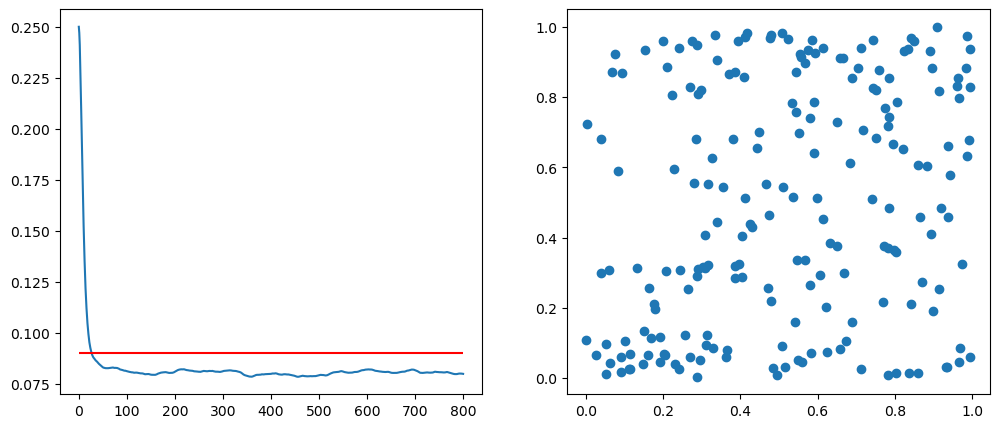

In [12]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

axes[0].plot(history["epsilon"])
axes[0].hlines(epsilon, xmin = 0, xmax = num_epochs, colors = "red")

axes[1].plot(X[0],history["X0"][-1],"o")

In [25]:
patience, min_delta, min_epochs, sample_pairs = 20, 1e-6, 20, 50
hide_progress = True
repetitions = 12

nested_simulations = []


for _ in tqdm(range(repetitions)):
    epsilon, mu = np.random.random(2) / 2
    rho = 16
    
    
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N": 100, "T": 64, "edge_per_t": 16, "evidences_per_t": 8, "parameters": [epsilon, mu, rho]}, 
                                                      {},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [oe.estimation_BC_model_from_data, 
                                                      {"epsilon0": 0.25,
                                                       "hide_progress": hide_progress, "patience": patience, "min_delta":min_delta,
                                                       "min_epochs":min_epochs, "sample_pairs": 50,"parameters": [epsilon, mu, rho], 
                                                       "summarized": True},
                                                      {"optimizer_name": ["adam", "RMSprop", "adagrad", "nadam", "SGD"], 
                                                       "num_epochs": [200, 400, 800],
                                                       "lr": [0.0001, 0.0005, 0.001, 0.005, 0.01,0.05, 0.1], 
                                                       "model_name": ["simple_BC", "BC_with_evidence", "BC_observed_positive"],
                                                       "minibatch_size": [0, 16, 32]
                                                      }, 
                                 1
                                ],
                                                     verbose1 = False, verbose2 = True
                               )


100%|████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [17:22:49<00:00, 5214.12s/it]


In [52]:
simulations_df = pd.DataFrame(nested_simulations)\
.assign(real_epsilon = lambda x: [u[0] for u in x["parameters"]],
        mu = lambda x: [u[1] for u in x["parameters"]],
        rho = lambda x: [u[2] for u in x["parameters"]]
       )\
.drop("parameters", axis = 1)\
.assign(distance_epsilon = lambda x: np.abs(x["real_epsilon"] -  x["epsilon_estimated"]))\
.assign(early_stopping = lambda x: x["num_epochs"])\
.assign(max_epochs = list(np.repeat(np.array([201, 401, 801]), 7*3*3)) * 60)

In [27]:
simulations_df.to_csv("/home/jacopo.lenti/Projects/learning-od-step-by-step/data/nested_simulations_230719.csv", index = None)

In [125]:
simulations_df = pd.read_csv("/home/jacopo.lenti/Projects/learning-od-step-by-step/data/nested_simulations_230719.csv")

## simple_BC

In [53]:
simple_BC_simulations = simulations_df.query("model_name == 'simple_BC'")

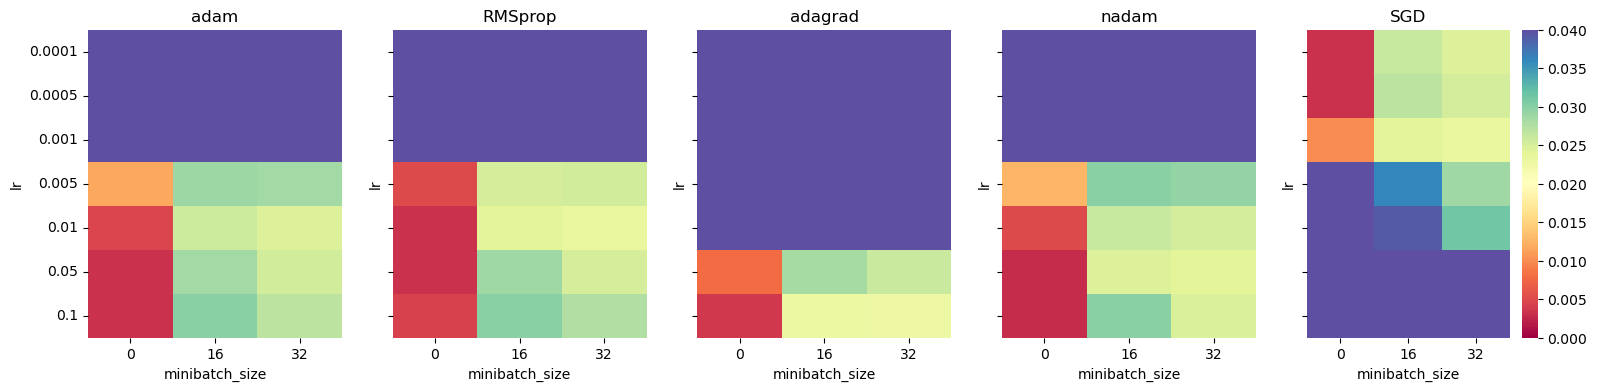

In [54]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (19, 4), sharey = True)

for ax, opt in zip(axes.ravel(), ["adam", "RMSprop", "adagrad", "nadam", "SGD"]):
    sns.heatmap(simple_BC_simulations.query("(optimizer_name == @opt)").groupby(["lr", "minibatch_size"]).mean()["distance_epsilon"].unstack(),
                cmap = "Spectral", vmin = 0.0, vmax = 0.04, ax = ax, cbar = opt == "SGD")
    ax.set_title(opt)

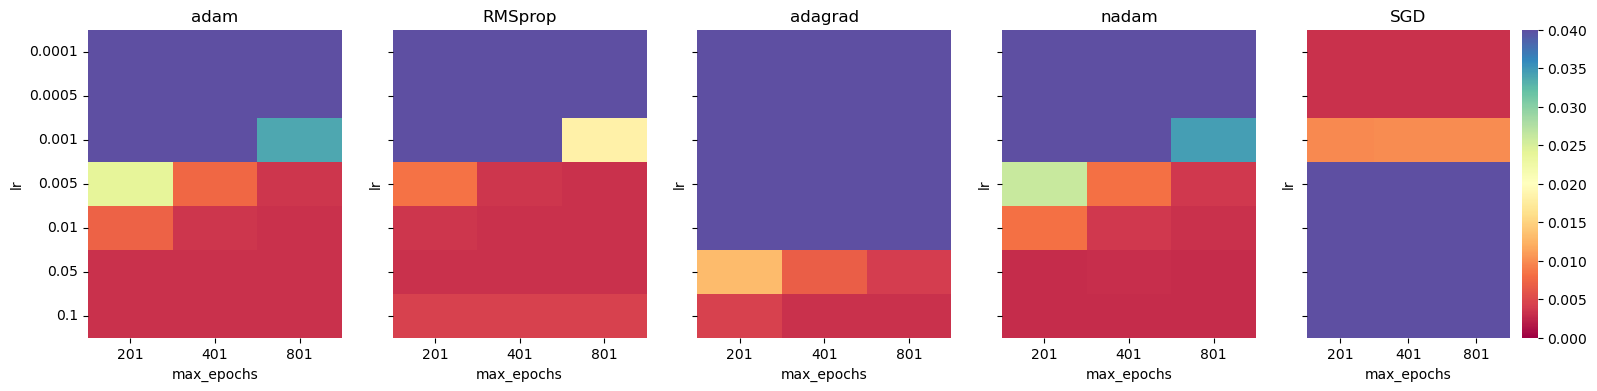

In [55]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (19, 4), sharey = True)

for ax, opt in zip(axes.ravel(), ["adam", "RMSprop", "adagrad", "nadam", "SGD"]):
    sns.heatmap(simple_BC_simulations.query("(minibatch_size == 0)&(optimizer_name == @opt)").groupby(["lr", "max_epochs"]).mean()["distance_epsilon"].unstack(),
                cmap = "Spectral", vmin = 0.0, vmax = 0.04, ax = ax, cbar = opt == "SGD")
    ax.set_title(opt)

In [95]:
simple_BC_simulations.query("minibatch_size == 0").groupby(["lr", "max_epochs", "optimizer_name"]).mean().sort_values("distance_epsilon")[["distance_epsilon", "early_stopping"]].reset_index().head(20)

,lr,max_epochs,optimizer_name,distance_epsilon,early_stopping
0,0.1000,201,nadam,0.002867,96.166667
1,0.1000,801,nadam,0.002877,146.166667
2,0.1000,401,nadam,0.002925,112.833333
3,0.0500,201,nadam,0.002932,116.500000
4,0.0500,801,nadam,0.002962,166.500000
5,0.0500,401,nadam,0.002969,133.166667
6,0.0005,201,SGD,0.003169,196.750000
7,0.1000,201,adam,0.003173,196.500000
8,0.1000,401,adam,0.003174,201.666667
9,0.1000,801,adam,0.003174,201.666667


In [58]:
best_simple_BC = simple_BC_simulations.query("(optimizer_name == 'nadam')&(max_epochs == 201)&(lr == 0.1)&(minibatch_size == 0)")

In [96]:
best_simple_BC

,N,T,edge_per_t,evidences_per_t,optimizer_name,num_epochs,lr,model_name,minibatch_size,epsilon_estimated,time,real_epsilon,mu,rho,distance_epsilon,X0_r2,last_iteration,early_stopping,max_epochs
621,100,64,16,8,nadam,94,0.1,simple_BC,0,0.458384,0.034672,0.468981,0.389923,16,0.010597,NaN,NaN,94,201
1566,100,64,16,8,nadam,143,0.1,simple_BC,0,0.087068,0.052904,0.083811,0.334617,16,0.003257,NaN,NaN,143,201
2511,100,64,16,8,nadam,58,0.1,simple_BC,0,0.206660,0.021377,0.207056,0.410620,16,0.000396,NaN,NaN,58,201
3456,100,64,16,8,nadam,201,0.1,simple_BC,0,0.249391,0.074255,0.251083,0.086207,16,0.001692,NaN,NaN,201,201
4401,100,64,16,8,nadam,83,0.1,simple_BC,0,0.428142,0.030630,0.425067,0.015995,16,0.003075,NaN,NaN,83,201
5346,100,64,16,8,nadam,136,0.1,simple_BC,0,0.094468,0.055608,0.095223,0.237902,16,0.000755,NaN,NaN,136,201
6291,100,64,16,8,nadam,61,0.1,simple_BC,0,0.359198,0.022659,0.355303,0.059853,16,0.003894,NaN,NaN,61,201
7236,100,64,16,8,nadam,103,0.1,simple_BC,0,0.473277,0.039049,0.473437,0.392884,16,0.000160,NaN,NaN,103,201
8181,100,64,16,8,nadam,74,0.1,simple_BC,0,0.379267,0.038494,0.382744,0.168174,16,0.003478,NaN,NaN,74,201
9126,100,64,16,8,nadam,57,0.1,simple_BC,0,0.296783,0.020595,0.299710,0.255609,16,0.002926,NaN,NaN,57,201


<AxesSubplot:xlabel='real_epsilon', ylabel='epsilon_estimated'>

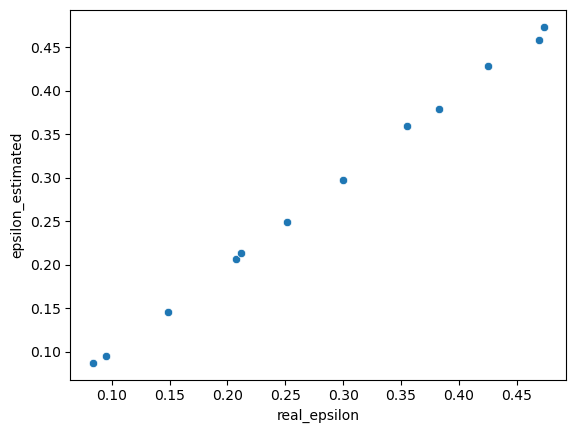

In [59]:
sns.scatterplot(data = best_simple_BC, x = "real_epsilon", y = "epsilon_estimated")

In [ ]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 4))

sns.scatterplot(data = simple_BC_simulations.query("(optimizer_name == 'RMSprop')&(minibatch_size == 0)&(lr == 0.1)"),
                x = "real_epsilon",
                y = "estimated_epsilon",
                ax = axes[0]
               )

sns.scatterplot(data = simple_BC_simulations.query("(optimizer_name == 'RMSprop')&(minibatch_size == 0)&(lr == 0.1)"),
                x = "mu",
                y = "distance_epsilon",
                ax = axes[1]
               )

## observed_positive_BC

In [60]:
obs_pos_BC_simulations = simulations_df.query("model_name == 'BC_observed_positive'")

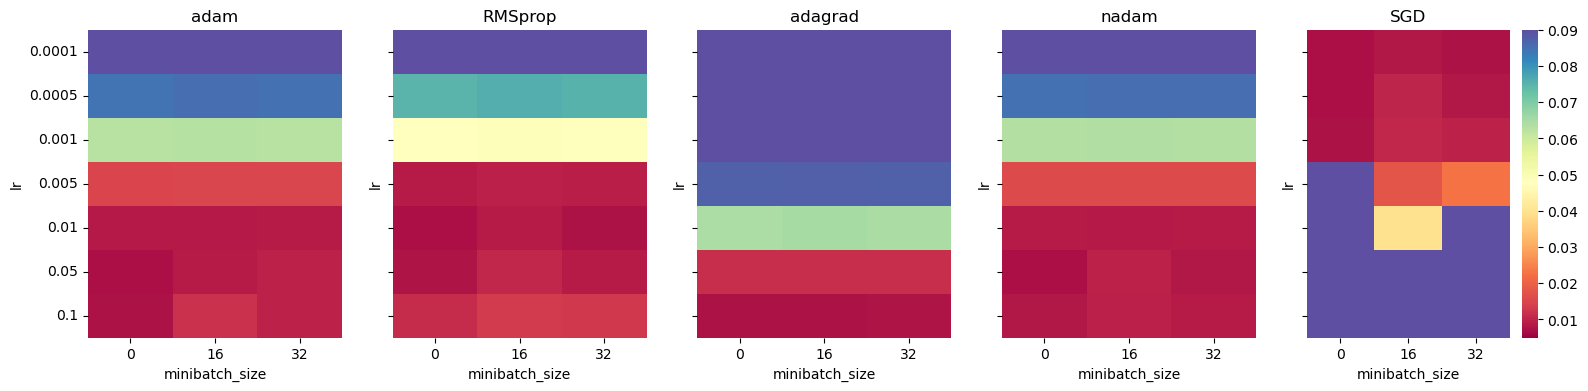

In [61]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (19, 4), sharey = True)

for ax, opt in zip(axes.ravel(), ["adam", "RMSprop", "adagrad", "nadam", "SGD"]):
    sns.heatmap(obs_pos_BC_simulations.query("(optimizer_name == @opt)").groupby(["lr", "minibatch_size"]).mean()["distance_epsilon"].unstack(),
                cmap = "Spectral", vmin = 0.005, vmax = 0.09, ax = ax, cbar = opt == "SGD")
    ax.set_title(opt)

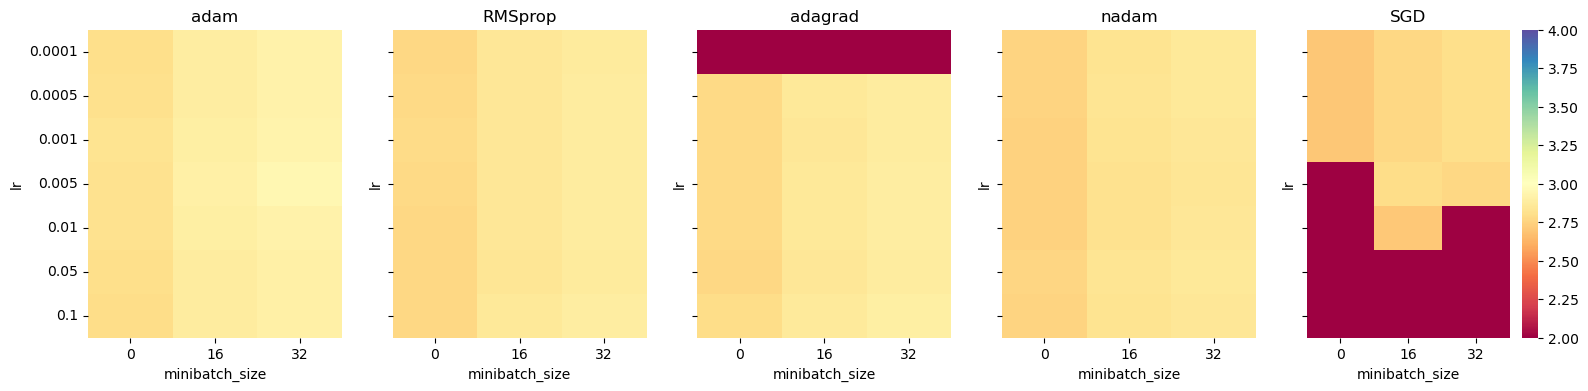

In [62]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (19, 4), sharey = True)

for ax, opt in zip(axes.ravel(), ["adam", "RMSprop", "adagrad", "nadam", "SGD"]):
    sns.heatmap(obs_pos_BC_simulations.query("(optimizer_name == @opt)").groupby(["lr", "minibatch_size"]).mean()["time"].unstack(),
                cmap = "Spectral", vmin = 2, vmax = 4, ax = ax, cbar = opt == "SGD")
    ax.set_title(opt)

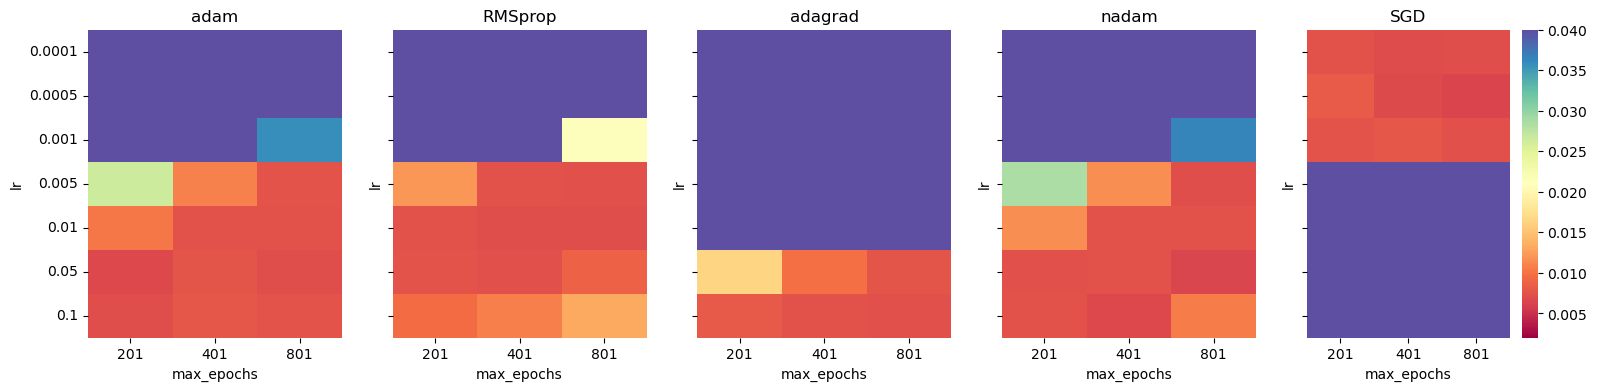

In [65]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (19, 4), sharey = True)

for ax, opt in zip(axes.ravel(), ["adam", "RMSprop", "adagrad", "nadam", "SGD"]):
    sns.heatmap(obs_pos_BC_simulations.query("(minibatch_size == 0)&(optimizer_name == @opt)").groupby(["lr", "max_epochs"]).mean()["distance_epsilon"].unstack(),
                cmap = "Spectral", vmin = 0.002, vmax = 0.04, ax = ax, cbar = opt == "SGD")
    ax.set_title(opt)

In [66]:
obs_pos_BC_simulations.query("minibatch_size == 0").groupby(["lr", "max_epochs", "optimizer_name"]).mean().sort_values("distance_epsilon")[["distance_epsilon", "early_stopping"]].reset_index().head(10)

,lr,max_epochs,optimizer_name,distance_epsilon,early_stopping
0,0.0005,801,SGD,0.006417,801.0
1,0.0500,801,nadam,0.006588,801.0
2,0.1000,401,nadam,0.006676,401.0
3,0.0500,201,adam,0.006734,201.0
4,0.0005,401,SGD,0.006808,401.0
5,0.0001,401,SGD,0.006981,401.0
6,0.1000,201,adam,0.007054,201.0
7,0.0100,801,RMSprop,0.007055,801.0
8,0.0050,801,nadam,0.007098,801.0
9,0.0001,801,SGD,0.007126,801.0


In [67]:
best_obs_pos_BC = obs_pos_BC_simulations.query("(optimizer_name == 'adam')&(max_epochs == 201)&(lr == 0.05)&(minibatch_size == 0)")


<AxesSubplot:xlabel='real_epsilon', ylabel='epsilon_estimated'>

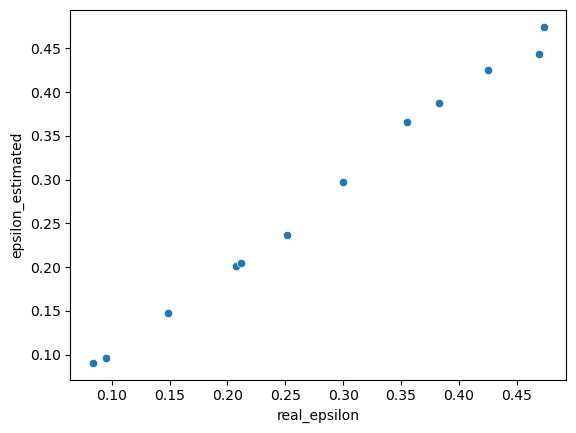

In [68]:
sns.scatterplot(data = best_obs_pos_BC, x = "real_epsilon", y = "epsilon_estimated")

## BC_with_evidences

In [176]:
patience, min_delta, min_epochs, sample_pairs = 20, 1e-6, 20, 50
hide_progress = True
repetitions = 12

nested_simulations = []


for _ in tqdm(range(repetitions)):
    epsilon, mu = np.random.random(2) / 2
    rho = 16
    
    
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N": 100, "T": 64, "edge_per_t": 16, "evidences_per_t": 8, "parameters": [epsilon, mu, rho]}, 
                                                      {},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [oe.estimation_BC_model_from_data, 
                                                      {"epsilon0": 0.25,
                                                       "hide_progress": hide_progress, "patience": patience, "min_delta":min_delta,
                                                       "min_epochs":min_epochs, "sample_pairs": 50,"parameters": [epsilon, mu, rho], 
                                                       "summarized": True},
                                                      {"optimizer_name": ["adam", "RMSprop", "nadam"], 
                                                       "num_epochs": [200, 400, 800],
                                                       "lr": [0.001, 0.005, 0.01,0.05, 0.1], 
                                                       "model_name": ["BC_with_evidence"],
                                                       "minibatch_size": [0, 16, 32],
                                                       "X0_lr_scale": [1, 10]
                                                       
                                                      }, 
                                 1
                                ],
                                                     verbose1 = False, verbose2 = True
                               )
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N": 100, "T": 64, "edge_per_t": 16, "evidences_per_t": 8, "parameters": [epsilon, mu, rho]}, 
                                                      {},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [oe.estimation_BC_model_from_data, 
                                                      {"epsilon0": 0.25,
                                                       "hide_progress": hide_progress, "patience": patience, "min_delta":min_delta,
                                                       "min_epochs":min_epochs, "sample_pairs": 50,"parameters": [epsilon, mu, rho], 
                                                       "summarized": True},
                                                      {"optimizer_name": ["SGD"], 
                                                       "num_epochs": [200, 400, 800],
                                                       "lr": [0.0001, 0.0005, 0.001, 0.005, 0.01], 
                                                       "model_name": ["BC_with_evidence"],
                                                       "minibatch_size": [0, 16, 32],
                                                       "X0_lr_scale": [1, 10]
                                                       
                                                      }, 
                                 1
                                ],
                                                     verbose1 = False, verbose2 = True
                               )



100%|█████████████████████████████████████| 270/270 [00:00<00:00, 452984.83it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 468734.30it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 277360.29it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 308825.22it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 439108.99it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 430266.75it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 454621.47it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 753467.78it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 774068.41it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 758514.45it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 755982.70it/s]

100%|█████████████████████████████████████| 270/270 [00:00<00:00, 734411.21it/s]

100%|███████████

In [177]:
simulations_df = pd.DataFrame(nested_simulations)\
.assign(real_epsilon = lambda x: [u[0] for u in x["parameters"]],
        mu = lambda x: [u[1] for u in x["parameters"]],
        rho = lambda x: [u[2] for u in x["parameters"]]
       )\
.drop("parameters", axis = 1)\
.assign(distance_epsilon = lambda x: np.abs(x["real_epsilon"] -  x["epsilon_estimated"]))

In [178]:
simulations_df.to_csv("/home/jacopo.lenti/Projects/learning-od-step-by-step/data/hyperparams_evidences_230729.csv", index = None)

In [121]:
#evidences_BC_simulations = pd.read_csv("/home/jacopo.lenti/Projects/learning-od-step-by-step/data/hyperparams_evidences_230728.csv")

In [180]:
evidences_BC_simulations = simulations_df.query("model_name == 'BC_with_evidence'")

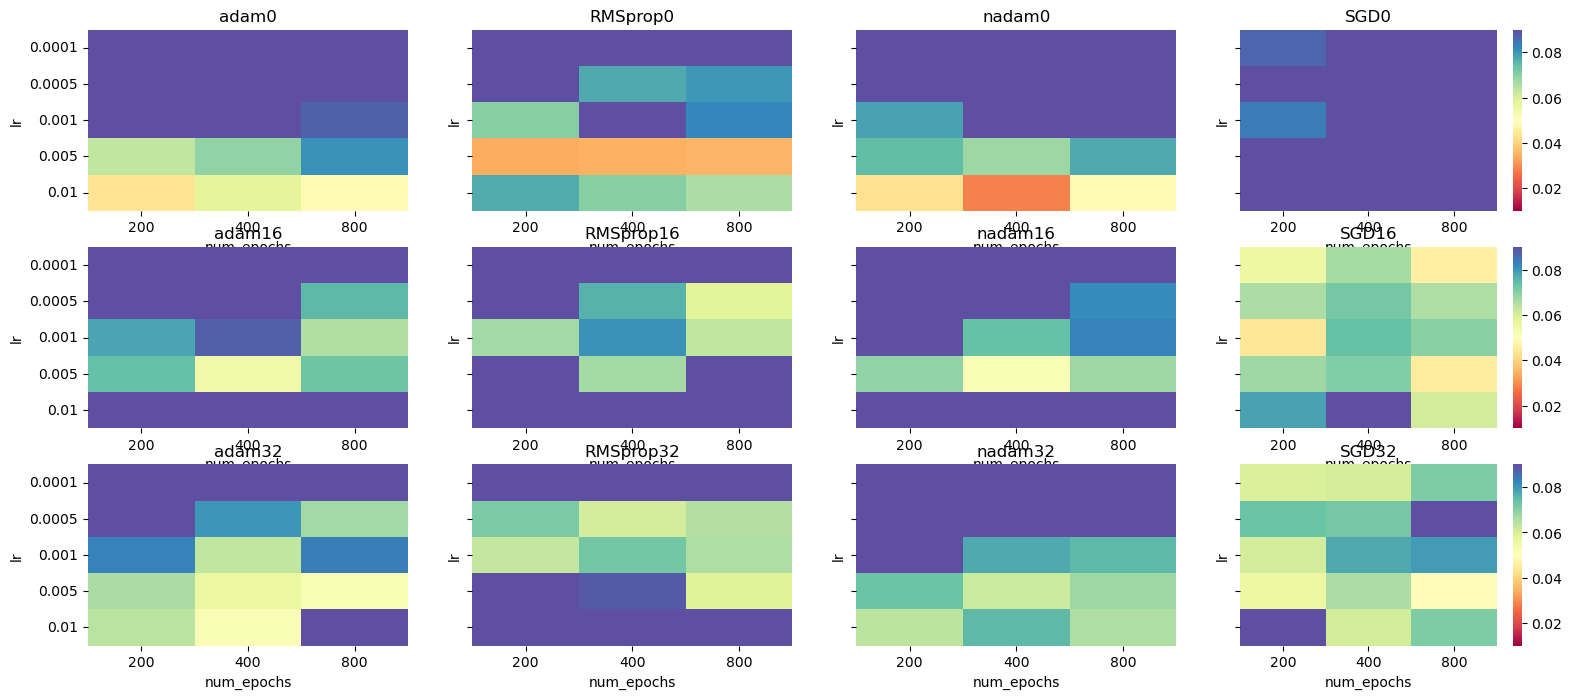

In [205]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize = (19, 8), sharey = True)

for i, opt in zip(np.arange(4), ["adam", "RMSprop", "nadam", "SGD"]):
    for j, minibatch in enumerate([0,16,32]):
        ax = axes[j,i]
        sns.heatmap(evidences_BC_simulations.query("(X0_lr_scale == 10)&(minibatch_size == @minibatch)&(optimizer_name == @opt)")\
                    .groupby(["lr", "num_epochs"]).mean()["distance_epsilon"].unstack(),
                    cmap = "Spectral", vmin = .01, vmax = .09, ax = ax, cbar = opt == "SGD")
        ax.set_title(opt + str(minibatch))

In [218]:
evidences_BC_simulations.groupby(["minibatch_size","optimizer_name", "lr", "X0_lr_scale", "num_epochs"]).mean().sort_values("X0_r2", ascending = False)[["X0_r2", "distance_epsilon"]].head(20)


X0_r2  \
minibatch_size optimizer_name lr    X0_lr_scale num_epochs             
0              RMSprop        0.100 10          800         0.706291   
                                    1           200         0.554715   
                                    10          200         0.485688   
                                    1           400         0.470963   
                                                800         0.416845   
                                    10          400         0.402881   
                              0.050 1           200         0.317304   
                                                800         0.188609   
                                                400         0.157391   
               nadam          0.100 1           400         0.123605   
                                    10          400         0.105548   
16             RMSprop        0.100 1           800         0.050429   
32             nadam          0.100 10          800         0.038497   
0              SGD            0.001 1           200         0.026780   
16             RMSprop        0.050 10          400         0.024440   
32             RMSprop        0.100 10          800         0.012837   
16             RMSprop        0.100 10          400         0.008611   
                              0.050 10          800         0.006873   
               nadam          0.100 10          400         0.002328   
32             SGD            0.005 1           200         0.000600   

                                                            distance_epsilon  
minibatch_size optimizer_name lr    X0_lr_scale num_epochs                    
0              RMSprop        0.100 10          800                 0.065904  
                                    1           200                 0.092645  
                                    10          200                 0.077122  
                                    1           400                 0.066114  
                                                800                 0.059410  
                                    10          400                 0.070110  
                              0.050 1           200                 0.036764  
                                                800                 0.035651  
                                                400                 0.023224  
               nadam          0.100 1           400                 0.035295  
                                    10          400                 0.028460  
16             RMSprop        0.100 1           800                 0.255854  
32             nadam          0.100 10          800                 0.065315  
0              SGD            0.001 1           200                 0.055449  
16             RMSprop        0.050 10          400                 0.066649  
32             RMSprop        0.100 10          800                 0.175745  
16             RMSprop        0.100 10          400                 0.267230  
                              0.050 10          800                 0.098051  
               nadam          0.100 10          400                 0.095850  
32             SGD            0.005 1           200                 0.079474

In [222]:
evidences_BC_simulations.query("(optimizer_name == 'RMSprop')&(lr == 0.100)&(minibatch_size == 0)").sort_values("distance_epsilon").tail(20)


,N,T,edge_per_t,evidences_per_t,optimizer_name,num_epochs,lr,model_name,minibatch_size,X0_lr_scale,epsilon_estimated,X0_r2,time,last_iteration,real_epsilon,mu,rho,distance_epsilon
2634,100,64,16,8,RMSprop,200,0.1,BC_with_evidence,0,1,0.491548,0.370012,4.568271,201,0.375775,0.193854,16,0.115773
3384,100,64,16,8,RMSprop,400,0.1,BC_with_evidence,0,1,0.615264,0.843432,9.031776,401,0.495146,0.054695,16,0.120118
2995,100,64,16,8,RMSprop,200,0.1,BC_with_evidence,0,10,0.538840,0.387674,4.556466,201,0.418517,0.166570,16,0.120323
2335,100,64,16,8,RMSprop,800,0.1,BC_with_evidence,0,10,0.560284,0.799394,18.169177,801,0.436474,0.096151,16,0.123810
175,100,64,16,8,RMSprop,800,0.1,BC_with_evidence,0,10,0.535511,0.540229,56.077372,801,0.405124,0.460093,16,0.130387
3414,100,64,16,8,RMSprop,800,0.1,BC_with_evidence,0,1,0.632166,0.831141,18.055031,801,0.495146,0.054695,16,0.137020
144,100,64,16,8,RMSprop,400,0.1,BC_with_evidence,0,1,0.545839,0.227541,30.266857,401,0.405124,0.460093,16,0.140715
174,100,64,16,8,RMSprop,800,0.1,BC_with_evidence,0,1,0.547410,0.451439,59.330213,801,0.405124,0.460093,16,0.142287
3355,100,64,16,8,RMSprop,200,0.1,BC_with_evidence,0,10,0.644158,0.760943,4.511957,201,0.495146,0.054695,16,0.149012
3385,100,64,16,8,RMSprop,400,0.1,BC_with_evidence,0,10,0.644337,0.866353,9.038032,401,0.495146,0.054695,16,0.149191


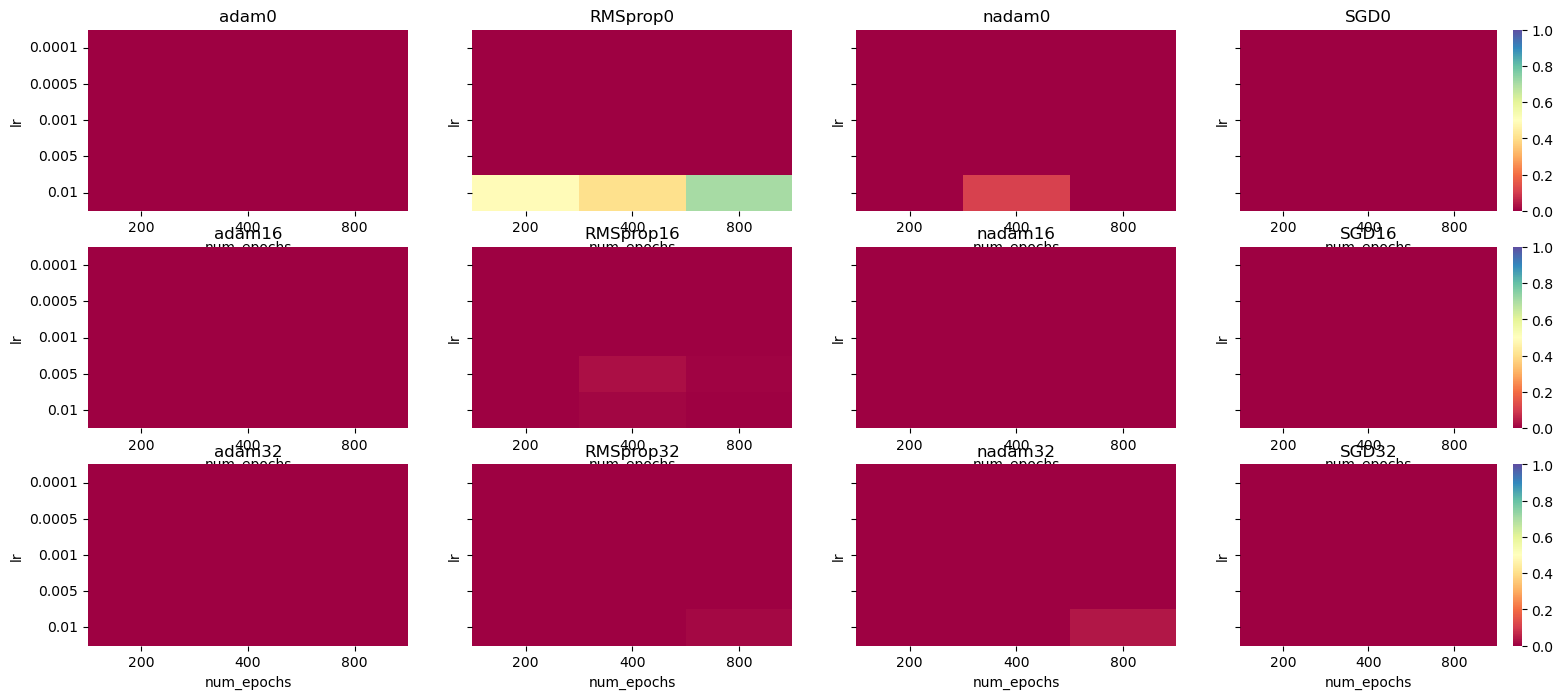

In [204]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize = (19, 8), sharey = True)

for i, opt in zip(np.arange(4), ["adam", "RMSprop", "nadam", "SGD"]):
    for j, minibatch in enumerate([0,16,32]):
        ax = axes[j,i]
        sns.heatmap(evidences_BC_simulations.query("(X0_lr_scale == 10)&(minibatch_size == @minibatch)&(optimizer_name == @opt)")\
                    .groupby(["lr", "num_epochs"]).mean()["X0_r2"].unstack(),
                    cmap = "Spectral", vmin = .0, vmax = 1., ax = ax, cbar = opt == "SGD")
        ax.set_title(opt + str(minibatch))

/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


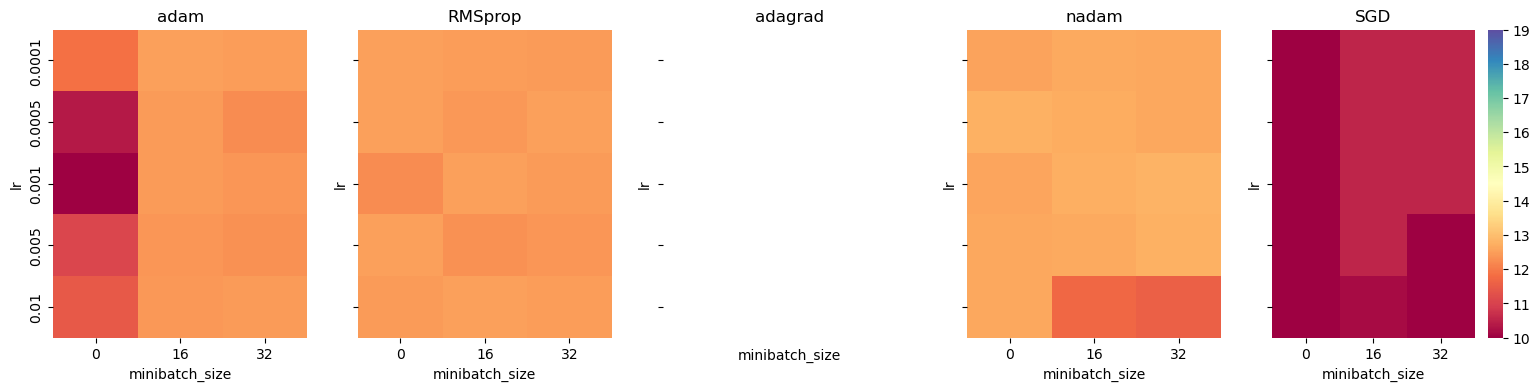

In [191]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (19, 4), sharey = True)

for ax, opt in zip(axes.ravel(), ["adam", "RMSprop", "adagrad", "nadam", "SGD"]):
    sns.heatmap(evidences_BC_simulations.query("(optimizer_name == @opt)").groupby(["lr", "minibatch_size"]).mean()["time"].unstack(),
                cmap = "Spectral", vmin = 10, vmax = 19, ax = ax, cbar = opt == "SGD")
    ax.set_title(opt)

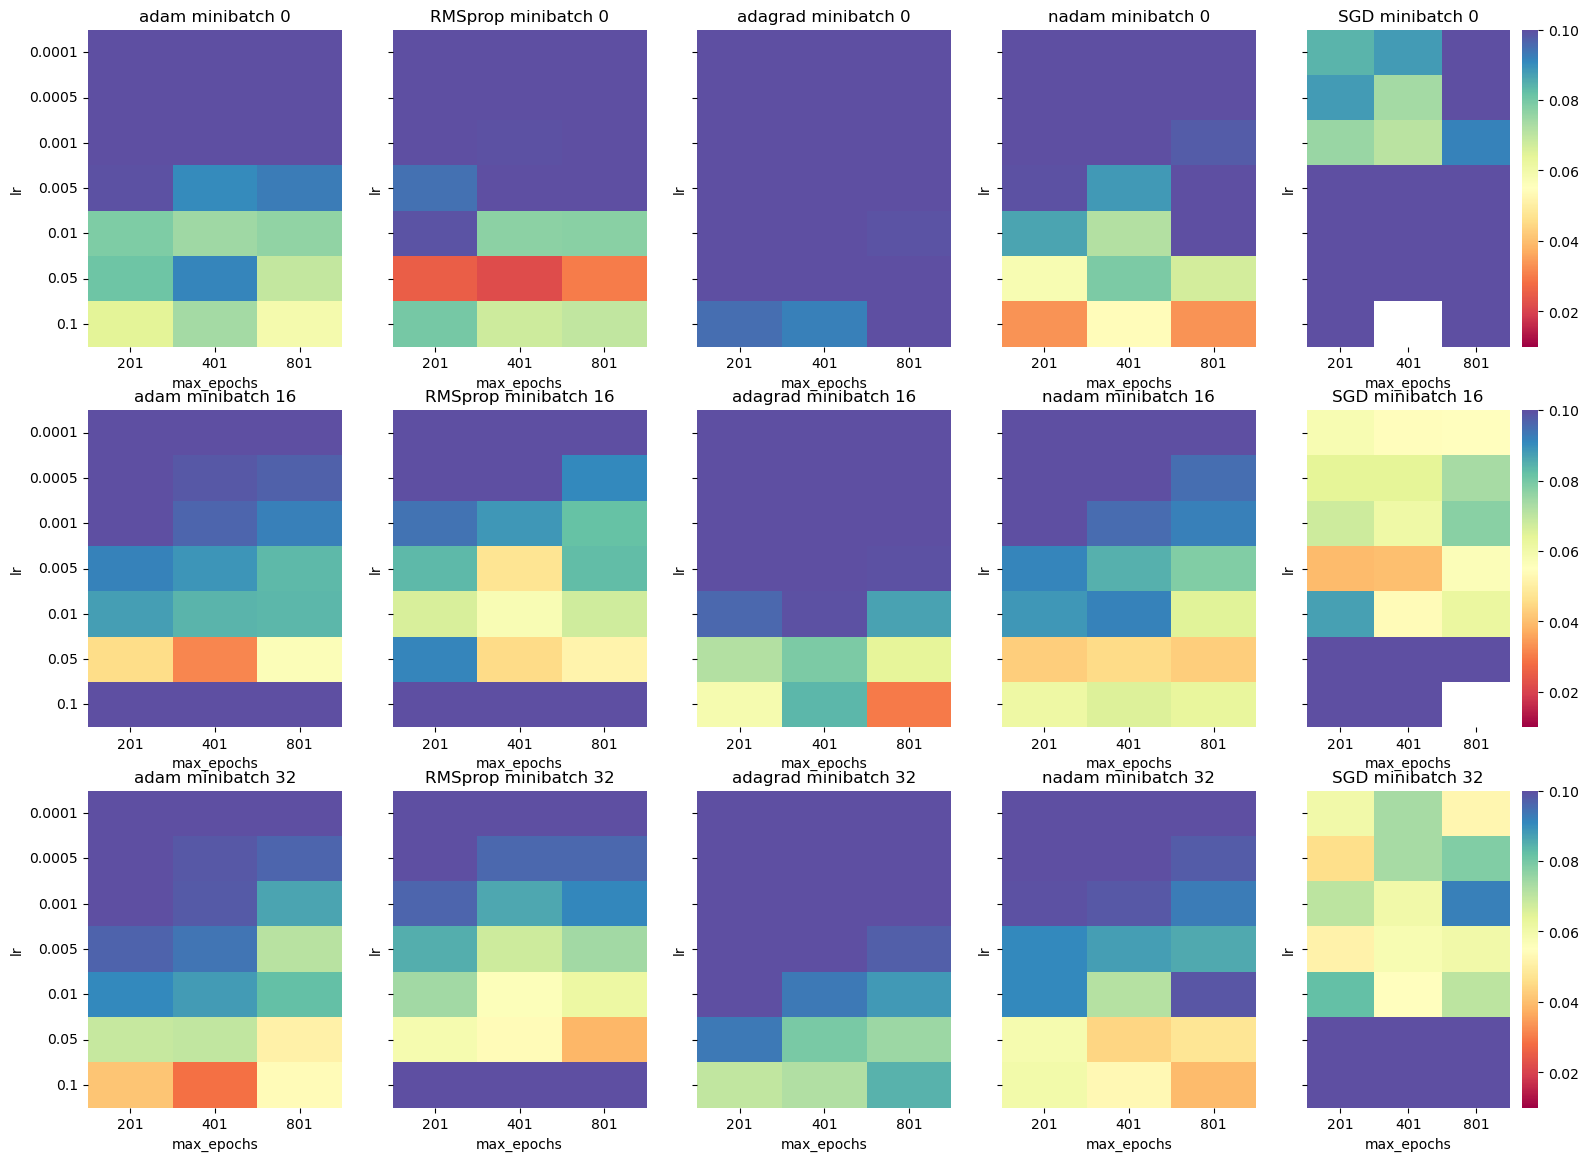

In [86]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (19, 14), sharey = True)

for j, opt in enumerate(["adam", "RMSprop", "adagrad", "nadam", "SGD"]):
    for i, minibatch in enumerate([0, 16, 32]):
        sns.heatmap(evidences_BC_simulations.query("(minibatch_size == @minibatch)&(optimizer_name == @opt)").groupby(["lr", "max_epochs"]).mean()["distance_epsilon"].unstack(),
                    cmap = "Spectral", vmin = 0.01, vmax = 0.1, ax = axes[i,j], cbar = opt == "SGD")
        axes[i,j].set_title(f"{opt} minibatch {minibatch}")

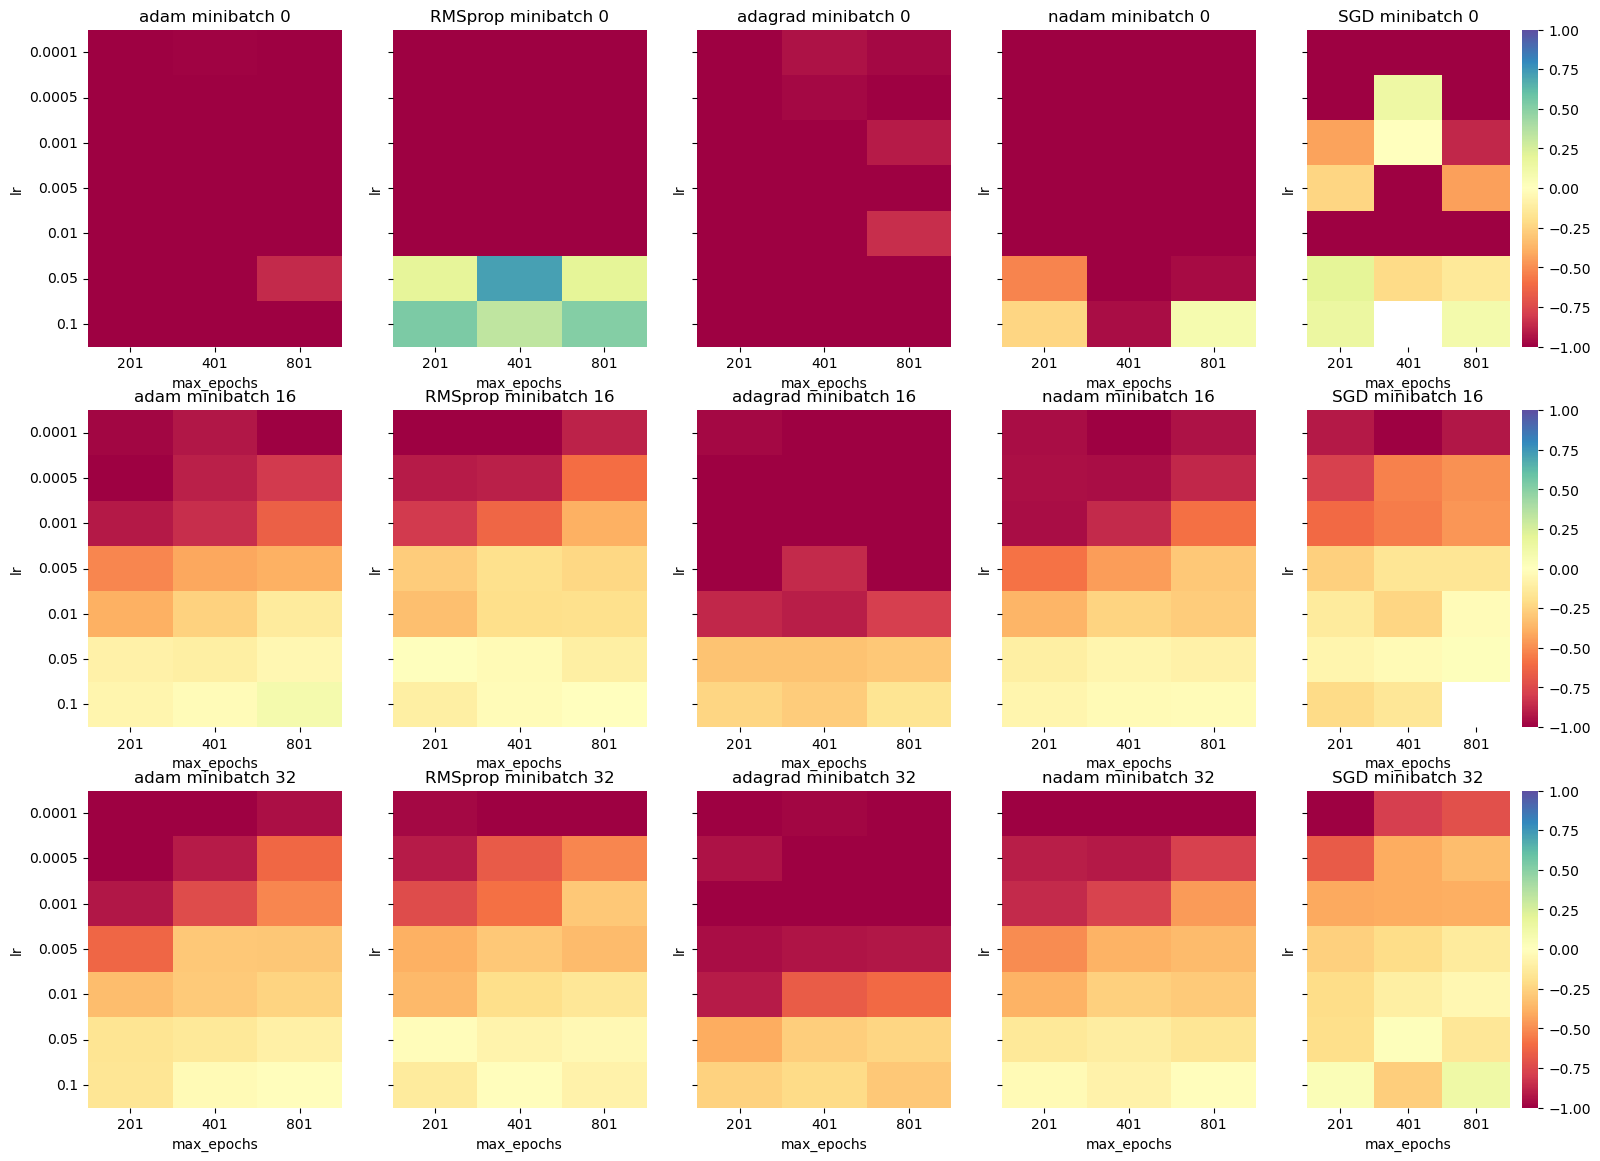

In [87]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (19, 14), sharey = True)

for j, opt in enumerate(["adam", "RMSprop", "adagrad", "nadam", "SGD"]):
    for i, minibatch in enumerate([0, 16, 32]):
        sns.heatmap(evidences_BC_simulations.query("(minibatch_size == @minibatch)&(optimizer_name == @opt)").groupby(["lr", "max_epochs"]).mean()["X0_r2"].unstack(),
                    cmap = "Spectral", vmin = -1, vmax = 1, ax = axes[i,j], cbar = opt == "SGD")
        axes[i,j].set_title(f"{opt} minibatch {minibatch}")

In [88]:
best_evidences_BC = evidences_BC_simulations.query("(optimizer_name == 'RMSprop')&(max_epochs == 401)&(lr == 0.05)&(minibatch_size == 0)")

In [93]:
best_evidences_BC[["real_epsilon", "epsilon_estimated", "time", "distance_epsilon", "X0_r2"]]

,real_epsilon,epsilon_estimated,time,distance_epsilon,X0_r2
300,0.468981,0.424852,9.054610,0.044129,-0.068165
1245,0.083811,0.090899,9.033557,0.007088,0.876890
2190,0.207056,0.219534,21.970364,0.012479,0.798629
3135,0.251083,0.260666,9.132948,0.009583,0.863591
4080,0.425067,0.452784,13.583452,0.027717,0.846131
5025,0.095223,0.109934,13.599185,0.014711,0.898048
5970,0.355303,0.384911,9.161909,0.029607,0.949654
6915,0.473437,0.521034,30.875435,0.047597,0.052425
7860,0.382744,0.416916,29.797202,0.034171,0.775020
8805,0.299710,0.320728,9.135993,0.021018,0.803056


In [94]:
best_evidences_BC[["real_epsilon", "epsilon_estimated", "time", "distance_epsilon", "X0_r2"]].mean()

real_epsilon          0.283593
epsilon_estimated     0.298181
time                 14.465291
distance_epsilon      0.021942
X0_r2                 0.717271
dtype: float64

<AxesSubplot:xlabel='real_epsilon', ylabel='epsilon_estimated'>

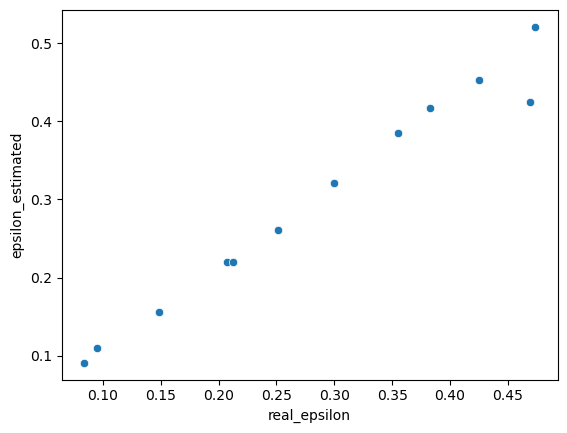

In [89]:
sns.scatterplot(data = best_evidences_BC, x = "real_epsilon", y = "epsilon_estimated")

In [117]:
reload(oe)

<module 'opinion_dynamics_models_estimation' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/src/opinion_dynamics_models_estimation.py'>

In [ ]:
X, edges, rho, num_epochs, sample_pairs,
epsilon0, optimizer_name,
lr, patience, min_delta,
min_epochs, hide_progress, minibatch_size

In [118]:
for _ in range(20):
    epsilon, mu = np.random.random(2) / 2
    X, edges, evidences = oe.simulate_BC(100,32,64,16,(epsilon, mu,16), model = "simple")

    history = oe.gradient_descent_BC_evidence_X(X, edges, evidences, mu, rho, 100, X0_lr_scale = 10,
                                                epsilon0 = 0.25, optimizer_name = "RMSprop", 
                                                lr = 0.05, patience = 10, min_delta = 1e-6, 
                                                min_epochs = 20, hide_progress = False, minibatch_size = 0)

    r2_sc = r2_score(history["X0"][-1], X[0])
    print("R2", r2_sc.item())
    print("error epsilon", np.abs(epsilon - history["epsilon"][-1]))
    print("MAE", torch.mean(torch.abs(history["X0"][-1] - X[0])).item())
    
    if r2_sc < 0.1:
        break
    

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.75it/s]


R2 0.5437002182006836
error epsilon 0.01203928334099813
MAE 0.11470725387334824


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.58it/s]


R2 0.6913087368011475
error epsilon 0.01567405087874113
MAE 0.10836894810199738


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.45it/s]


R2 0.14627158641815186
error epsilon 0.023345584959754806
MAE 0.2097482830286026


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.14it/s]


R2 0.7679274082183838
error epsilon 0.03358888758609313
MAE 0.10713665187358856


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 19.10it/s]


R2 0.8903045058250427
error epsilon 0.014644190001564486
MAE 0.0704902857542038


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.58it/s]


R2 0.8339912295341492
error epsilon 0.03980423034854974
MAE 0.09153985232114792


100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]


R2 0.936503529548645
error epsilon 0.04294804130710672
MAE 0.06035526096820831


100%|█████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]


R2 0.9271892309188843
error epsilon 0.03618861637691856
MAE 0.059285033494234085


100%|█████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


R2 0.5103665590286255
error epsilon 0.02796156108347031
MAE 0.14746589958667755


100%|█████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s]


R2 0.8182821273803711
error epsilon 0.007957772609164443
MAE 0.09265641868114471


100%|█████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


R2 0.6418956518173218
error epsilon 0.03497015444937662
MAE 0.10577897727489471


100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


R2 0.9502098560333252
error epsilon 0.03041541930642294
MAE 0.05498599633574486


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.41it/s]


R2 0.7253977060317993
error epsilon 0.00878042568536154
MAE 0.10244302451610565


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.59it/s]


R2 0.8761111497879028
error epsilon 0.026329183242336962
MAE 0.07805079966783524


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 16.74it/s]


R2 0.6056420803070068
error epsilon 0.006482772536426068
MAE 0.10308180004358292


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 18.43it/s]


R2 0.17913979291915894
error epsilon 0.02609166621677006
MAE 0.1720268428325653


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 16.15it/s]


R2 0.7075810432434082
error epsilon 0.006246044420478644
MAE 0.10941505432128906


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.91it/s]


R2 0.9225444197654724
error epsilon 0.026878537276460307
MAE 0.0637463927268982


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 16.88it/s]


R2 0.7829793095588684
error epsilon 0.01551483440551274
MAE 0.08816075325012207


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 19.36it/s]

R2 0.7195206880569458
error epsilon 0.007615061458043304
MAE 0.11689797043800354


In [119]:
epsilon,mu, history["epsilon"][-1]

(0.44788591403660866, 0.33974886520474623, 0.45550097549465196)

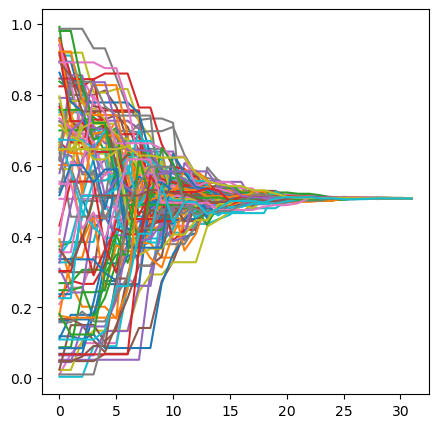

In [120]:
oe.sod.print_opinion_trajectory(X)

<AxesSubplot:>

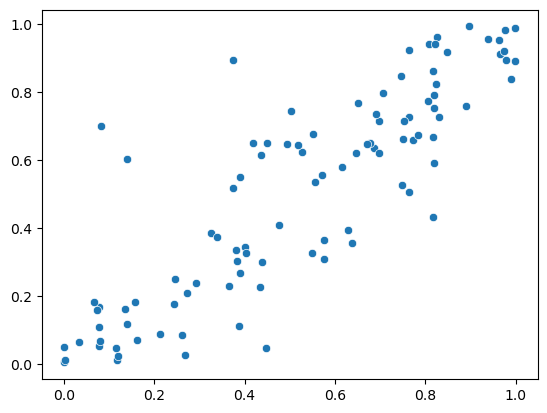

In [121]:
sns.scatterplot(x = history["X0"][-1], y = X[0])

In [94]:
reload(oe)

<module 'opinion_dynamics_models_estimation' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/src/opinion_dynamics_models_estimation.py'>

In [402]:
nested_simulations_rmsprop_evidences = []

for j in tqdm(range(4)):
    epsilon, mu = np.random.random(2) / 2
    rho = 16
    
    nested_simulations_rmsprop_evidences += repeat_function.nested_rep([oe.simulate_BC, 
                                                          {"N": 100, "T": 64, "edge_per_t": 16, 
                                                           "evidences_per_t": 8, "parameters": [epsilon, mu, rho]}, 
                                                          {},
                                                          1], 
                                                         ["X", "edges", "evidences"],
                                                         [oe.estimation_BC_model_from_data, 
                                                          {"epsilon0": 0.25,
                                                           "hide_progress": hide_progress, "patience": patience, "min_delta":min_delta,
                                                           "min_epochs":min_epochs, "sample_pairs": 50,"parameters": [epsilon, mu, rho], 
                                                           "summarized": True},
                                                          {"optimizer_name": ["RMSprop"], 
                                                           "num_epochs": [200],
                                                           "lr": [0.05], 
                                                           "model_name": ["BC_with_evidence"],
                                                           "minibatch_size": [0],
                                                           "X0_lr_scale": [1, 5, 10, 15, 20]

                                                          }, 
                                     1
                                    ],
                                                         verbose1 = False, verbose2 = True
                                   )



  2%|▊                                          | 4/200 [00:00<00:05, 36.49it/s]

flip
flip
inf loss
flip
flip



100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 42.75it/s]

100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 42.89it/s]

  2%|▊                                          | 4/200 [00:00<00:04, 39.22it/s]

flip
flip
inf loss
flip
flip



  0%|                                                     | 0/4 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [323]:
pd.DataFrame(nested_simulations_rmsprop_evidences)#.groupby(["num_epochs", "X0_lr_scale", "lr"]).mean()[["X0_r2", "distance_epsilon"]]


,N,T,edge_per_t,evidences_per_t,parameters,optimizer_name,num_epochs,lr,model_name,minibatch_size,X0_lr_scale,epsilon_estimated,X0_r2,time,last_iteration,real_epsilon,mu,rho,distance_epsilon
0,100,64,16,8,"[0.42888334631254166, 0.19575583901128335, 16]",RMSprop,200,0.05,BC_with_evidence,0,1,0.372952,-0.409707,4.614611,201,0.428883,0.195756,16,0.055932
1,100,64,16,8,"[0.42888334631254166, 0.19575583901128335, 16]",RMSprop,200,0.05,BC_with_evidence,0,5,0.444233,0.427279,4.606860,201,0.428883,0.195756,16,0.015350
2,100,64,16,8,"[0.42888334631254166, 0.19575583901128335, 16]",RMSprop,200,0.05,BC_with_evidence,0,10,0.393939,-0.037257,4.599175,201,0.428883,0.195756,16,0.034944
3,100,64,16,8,"[0.42888334631254166, 0.19575583901128335, 16]",RMSprop,200,0.05,BC_with_evidence,0,15,0.378781,0.279678,4.600835,201,0.428883,0.195756,16,0.050102
4,100,64,16,8,"[0.42888334631254166, 0.19575583901128335, 16]",RMSprop,200,0.05,BC_with_evidence,0,20,0.385345,-0.545450,4.596314,201,0.428883,0.195756,16,0.043538
5,100,64,16,8,"[0.24863667301093878, 0.4900405814468676, 16]",RMSprop,200,0.05,BC_with_evidence,0,1,0.243943,0.264955,4.604282,201,0.248637,0.490041,16,0.004693
6,100,64,16,8,"[0.24863667301093878, 0.4900405814468676, 16]",RMSprop,200,0.05,BC_with_evidence,0,5,0.244687,0.262796,4.602317,201,0.248637,0.490041,16,0.003950
7,100,64,16,8,"[0.24863667301093878, 0.4900405814468676, 16]",RMSprop,200,0.05,BC_with_evidence,0,10,0.247252,0.507268,4.601969,201,0.248637,0.490041,16,0.001384
8,100,64,16,8,"[0.24863667301093878, 0.4900405814468676, 16]",RMSprop,200,0.05,BC_with_evidence,0,15,0.238041,0.661312,4.602747,201,0.248637,0.490041,16,0.010596
9,100,64,16,8,"[0.24863667301093878, 0.4900405814468676, 16]",RMSprop,200,0.05,BC_with_evidence,0,20,0.245072,0.488649,4.606101,201,0.248637,0.490041,16,0.003564


## BC backfire

In [401]:
reload(oe)

<module 'opinion_dynamics_models_estimation' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/src/opinion_dynamics_models_estimation.py'>

In [179]:
patience, min_delta, min_epochs, sample_pairs = 20, 1e-5, 20, 50
hide_progress = True
repetitions = 15

nested_simulations = []


for _ in tqdm(range(repetitions)):
    epsilon_plus, epsilon_minus = np.random.random(2) / 2
    epsilon_minus += 0.5
    mu_plus, mu_minus = np.random.random(2) / 2
    rho = 16
    
    
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N": 100, "T": 64, "edge_per_t": 16, "evidences_per_t": 8, "model": "backfire",
                                                       "parameters": [epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho]}, 
                                                      {},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [oe.estimation_BC_model_from_data, 
                                                      {"epsilon0_plus": 0.25, "epsilon0_minus": 0.75,
                                                       "hide_progress": hide_progress, "patience": patience, "min_delta":min_delta,
                                                       "min_epochs":min_epochs, "sample_pairs": 50,"parameters": [epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho], 
                                                       "summarized": True},
                                                      {"optimizer_name": ["adam", "RMSprop", "nadam"], 
                                                       "num_epochs": [200, 400, 800],
                                                       "lr": [0.001,0.005,0.01,0.05, 0.1], 
                                                       "model_name": ["BC_backfire"],
                                                       "minibatch_size": [0], 
                                                       "X0_lr_scale": [1, 10, 20]
                                                      }, 
                                 1
                                ],
                                                     verbose1 = False, verbose2 = True
                               )
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N": 100, "T": 64, "edge_per_t": 16, "evidences_per_t": 8, "model": "backfire",
                                                       "parameters": [epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho]}, 
                                                      {},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [oe.estimation_BC_model_from_data, 
                                                      {"epsilon0_plus": 0.25, "epsilon0_minus": 0.75,
                                                       "hide_progress": hide_progress, "patience": patience, "min_delta":min_delta,
                                                       "min_epochs":min_epochs, "sample_pairs": 50,
                                                       "parameters": [epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho], 
                                                       "summarized": True},
                                                      {"optimizer_name": ["SGD"], 
                                                       "num_epochs": [200, 400, 800],
                                                       "lr": [0.00001,0.00005, 0.0001,0.0005,0.001],
                                                       "model_name": ["BC_backfire"],
                                                       "minibatch_size": [0], 
                                                       "X0_lr_scale": [1, 10, 20]
                                                      }, 
                                 1
                                ],
                                                     verbose1 = False, verbose2 = True
                               )


  0%|                                                    | 0/15 [00:10<?, ?it/s]

flip


NameError: name 'self' is not defined

In [313]:
reload(oe)

<module 'opinion_dynamics_models_estimation' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/src/opinion_dynamics_models_estimation.py'>

In [405]:
for _ in range(20):
    epsilon_plus, epsilon_minus, mu_plus, mu_minus = np.random.random(4) / 2
    epsilon_minus += 0.5
    
    X, edges, evidences = oe.simulate_BC(100,64,8,16,(epsilon_plus, epsilon_minus, mu_plus, mu_minus,16), model = "backfire")
    
    history = oe.gradient_descent_BC_evidence_X_backfire(X, edges, evidences, mu_plus, mu_minus, rho, 200, X0_lr_scale = 10,
                                                optimizer_name = "RMSprop", 
                                                lr = 0.05, patience = 10, min_delta = 1e-6, 
                                                min_epochs = 20, hide_progress = True, minibatch_size = 0)
    
    r2_sc = r2_score(history["X0"][-1], X[0])
    print(r2_sc.item(), np.abs(epsilon_plus - history["epsilon_plus"][-1]), 
          np.abs(epsilon_minus - history["epsilon_minus"][-1]))
    if r2_sc < 0:
        break 
        


0.873023271560669 0.014849061441563116 0.054061590621955036
0.675851583480835 0.02388032732172901 0.03689157061327897
0.6706579327583313 0.007792660482951311 0.036848718710897344
0.7630048990249634 0.0037025272103666795 0.021484330864364187
0.5964654088020325 0.019441913970976 0.01619152225819298
0.7485858201980591 0.0006903774657209261 0.013984844962689702
0.8616212606430054 0.006210865405617716 0.044928909206712
0.7156453132629395 0.0005069274011929858 0.01238156193441553
0.5893796682357788 0.02822739678298769 0.01390086295383075
0.6821845769882202 0.01747333588429109 0.06047751495242393
0.6339552402496338 0.0065517196769313835 0.025071639722805683
0.7939751148223877 0.00956533218805461 0.04835998204340941
0.7692375779151917 0.03168311884889258 0.004979255938604488
0.520637035369873 0.019930963489096454 0.025254566131772238
0.8810821175575256 0.02293518274951223 0.06845525119121854
0.8275680541992188 0.017212595681583787 0.03517980693939793
0.8727496862411499 0.00023000143064755285 0

In [288]:
patience, min_delta, min_epochs, sample_pairs = 20, 1e-5, 20, 50
hide_progress = True
repetitions = 7

nested_simulations = []


for _ in tqdm(range(repetitions)):
    epsilon_plus, epsilon_minus = np.random.random(2) / 2
    epsilon_minus += 0.5
    mu_plus, mu_minus = np.random.random(2) / 2
    rho = 16
    
    
    nested_simulations += repeat_function.nested_rep([oe.simulate_BC, 
                                                      {"N": 100, "T": 64, "edge_per_t": 16, "evidences_per_t": 8, "model": "backfire",
                                                       "parameters": [epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho]}, 
                                                      {},
                                                      1], 
                                                     ["X", "edges", "evidences"],
                                                     [oe.estimation_BC_model_from_data, 
                                                      {"epsilon0_plus": 0.25, "epsilon0_minus": 0.75,
                                                       "hide_progress": hide_progress, "patience": patience, "min_delta":min_delta,
                                                       "min_epochs":min_epochs, "sample_pairs": 50,"parameters": [epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho], 
                                                       "summarized": True},
                                                      {"optimizer_name": ["RMSprop"], 
                                                       "num_epochs": [200,400],
                                                       "lr": [0.05], 
                                                       "model_name": ["BC_backfire"],
                                                       "minibatch_size": [0], 
                                                       "X0_lr_scale": [1]
                                                      }, 
                                 1
                                ],
                                                     verbose1 = False, verbose2 = True
                               )

100%|█████████████████████████████████████████████| 7/7 [04:24<00:00, 37.83s/it]


In [285]:
simulations_df = pd.DataFrame(nested_simulations)\
.assign(real_epsilon_plus = lambda x: [u[0] for u in x["parameters"]],
        real_epsilon_minus = lambda x: [u[1] for u in x["parameters"]],
        mu_plus = lambda x: [u[2] for u in x["parameters"]],
        mu_minus = lambda x: [u[3] for u in x["parameters"]],
        rho = lambda x: [u[4] for u in x["parameters"]]
       )\
.drop("parameters", axis = 1)\
.assign(distance_epsilon_plus = lambda x: np.abs(x["real_epsilon_plus"] -  x["epsilon_plus_estimated"]))\
.assign(distance_epsilon_minus = lambda x: np.abs(x["real_epsilon_minus"] -  x["epsilon_minus_estimated"]))

In [286]:
simulations_df.to_csv("/home/jacopo.lenti/Projects/learning-od-step-by-step/data/nested_simulations_backfire_230729.csv", index = None)

In [161]:
simulations_df = pd.read_csv("/home/jacopo.lenti/Projects/learning-od-step-by-step/data/nested_simulations_backfire_230729.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/home/jacopo.lenti/Projects/learning-od-step-by-step/data/nested_simulations_backfire_230728.csv'

In [86]:
simulations_df

,N,T,edge_per_t,evidences_per_t,model,optimizer_name,num_epochs,lr,model_name,minibatch_size,...,X0_r2,time,last_iteration,real_epsilon_plus,real_epsilon_minus,mu_plus,mu_minus,rho,distance_epsilon_plus,distance_epsilon_minus
0,100,64,16,8,backfire,adam,200,0.001,BC_backfire,0,...,-0.714961,9.627657,201,0.301033,0.542646,0.289772,0.006416,16,0.016088,0.167918
1,100,64,16,8,backfire,adam,200,0.001,BC_backfire,0,...,-0.937326,9.519850,201,0.301033,0.542646,0.289772,0.006416,16,0.017757,0.168166
2,100,64,16,8,backfire,adam,200,0.001,BC_backfire,0,...,-0.659715,9.523306,201,0.301033,0.542646,0.289772,0.006416,16,0.017935,0.168703
3,100,64,16,8,backfire,adam,200,0.005,BC_backfire,0,...,-0.995957,9.505738,201,0.301033,0.542646,0.289772,0.006416,16,0.005666,0.049418
4,100,64,16,8,backfire,adam,200,0.005,BC_backfire,0,...,-0.979811,9.513315,201,0.301033,0.542646,0.289772,0.006416,16,0.020954,0.003528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,100,64,16,8,backfire,nadam,1200,0.050,BC_backfire,0,...,0.404253,57.657992,1201,0.404232,0.807824,0.066590,0.423946,16,0.116660,0.127010
1856,100,64,16,8,backfire,nadam,1200,0.050,BC_backfire,0,...,0.469919,58.358490,1201,0.404232,0.807824,0.066590,0.423946,16,0.100138,0.093406
1857,100,64,16,8,backfire,nadam,1200,0.100,BC_backfire,0,...,-9.477177,161.756950,1201,0.404232,0.807824,0.066590,0.423946,16,0.246452,0.499186
1858,100,64,16,8,backfire,nadam,1200,0.100,BC_backfire,0,...,0.271409,117.664537,1201,0.404232,0.807824,0.066590,0.423946,16,0.086125,0.080586


In [87]:
from scipy.special import logit
simulations_df = simulations_df.assign(epsilon_plus_estimated_ = lambda x: logit(x["epsilon_plus_estimated"]),
                                       epsilon_minus_estimated_ = lambda x: logit(x["epsilon_minus_estimated"])
                                      )\
.assign(distance_epsilon_plus_ = lambda x: np.abs(x["real_epsilon_plus"] -  x["epsilon_plus_estimated_"]),
        distance_epsilon_minus_ = lambda x: np.abs(x["real_epsilon_minus"] -  x["epsilon_minus_estimated_"]))#\


In [37]:
df = simulations_df.query("(optimizer_name == 'adam')&(num_epochs == 800)&(lr == 0.05)").drop(["N", "T", "distance_epsilon_plus", "distance_epsilon_minus",
                                                                                          "epsilon_plus_estimated", "epsilon_minus_estimated", "rho",
                                                                                          "optimizer_name", "num_epochs", "lr",  "model", "minibatch_size", "model_name",   "edge_per_t", "evidences_per_t"], axis = 1)

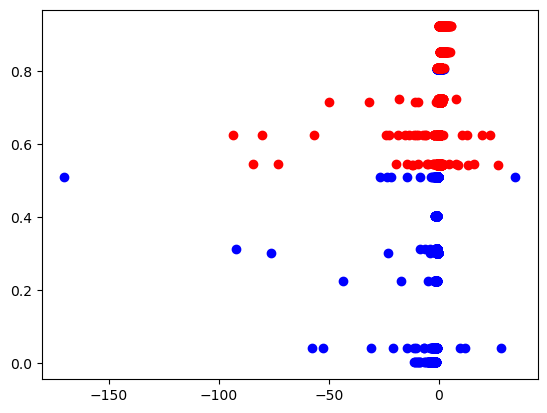

In [88]:
plt.plot(simulations_df["epsilon_plus_estimated_"], simulations_df["real_epsilon_plus"], "o", color = "blue")
plt.plot(simulations_df["epsilon_minus_estimated_"], simulations_df["real_epsilon_minus"], "o", color = "red")

## Distance epsilon+ and epsilon- varying scale

scale 1


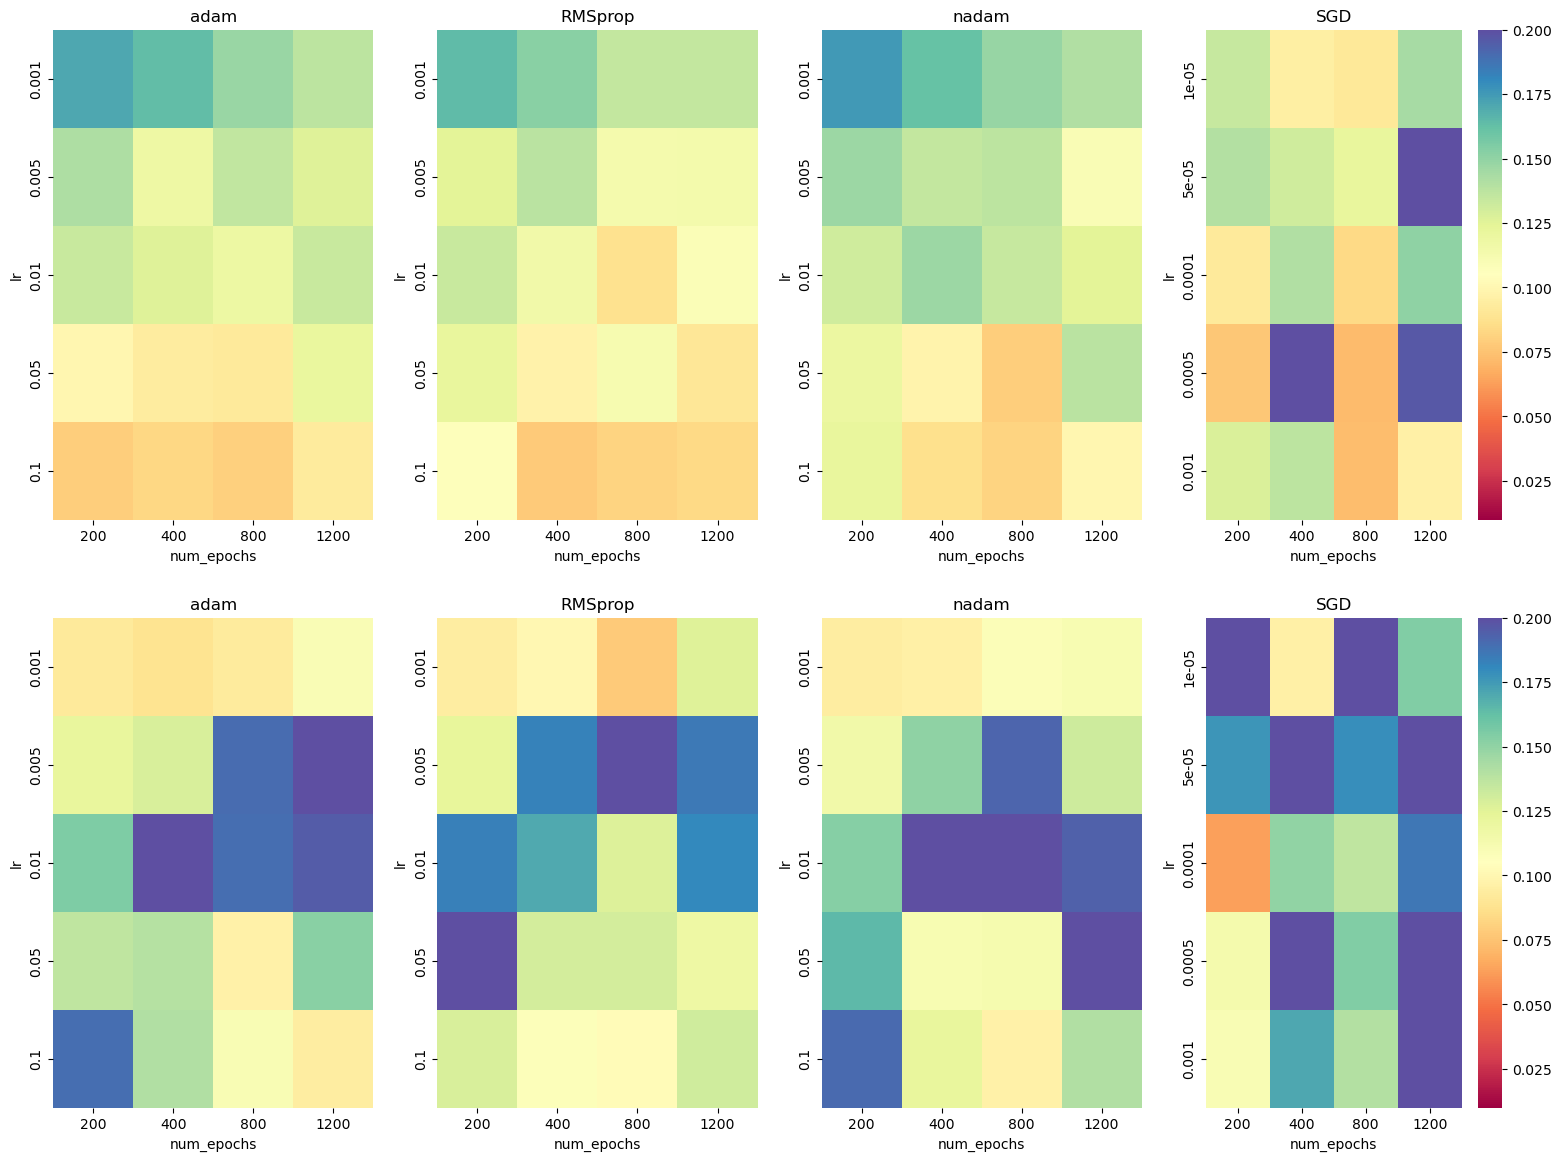

In [97]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (19, 14))

print("scale 1")

for j, opt in enumerate(["adam", "RMSprop", "nadam", "SGD"]):
    for i, sign in enumerate(["plus", "minus"]):
        sns.heatmap(simulations_df.query("(X0_lr_scale == 1)&(optimizer_name == @opt)").groupby(["lr", "num_epochs"]).mean()[f"distance_epsilon_{sign}"].unstack(),
                    cmap = "Spectral", vmin = 0.01, vmax = 0.2, ax = axes[i,j], cbar = opt == "SGD")
        axes[i,j].set_title(f"{opt}")


scale 10


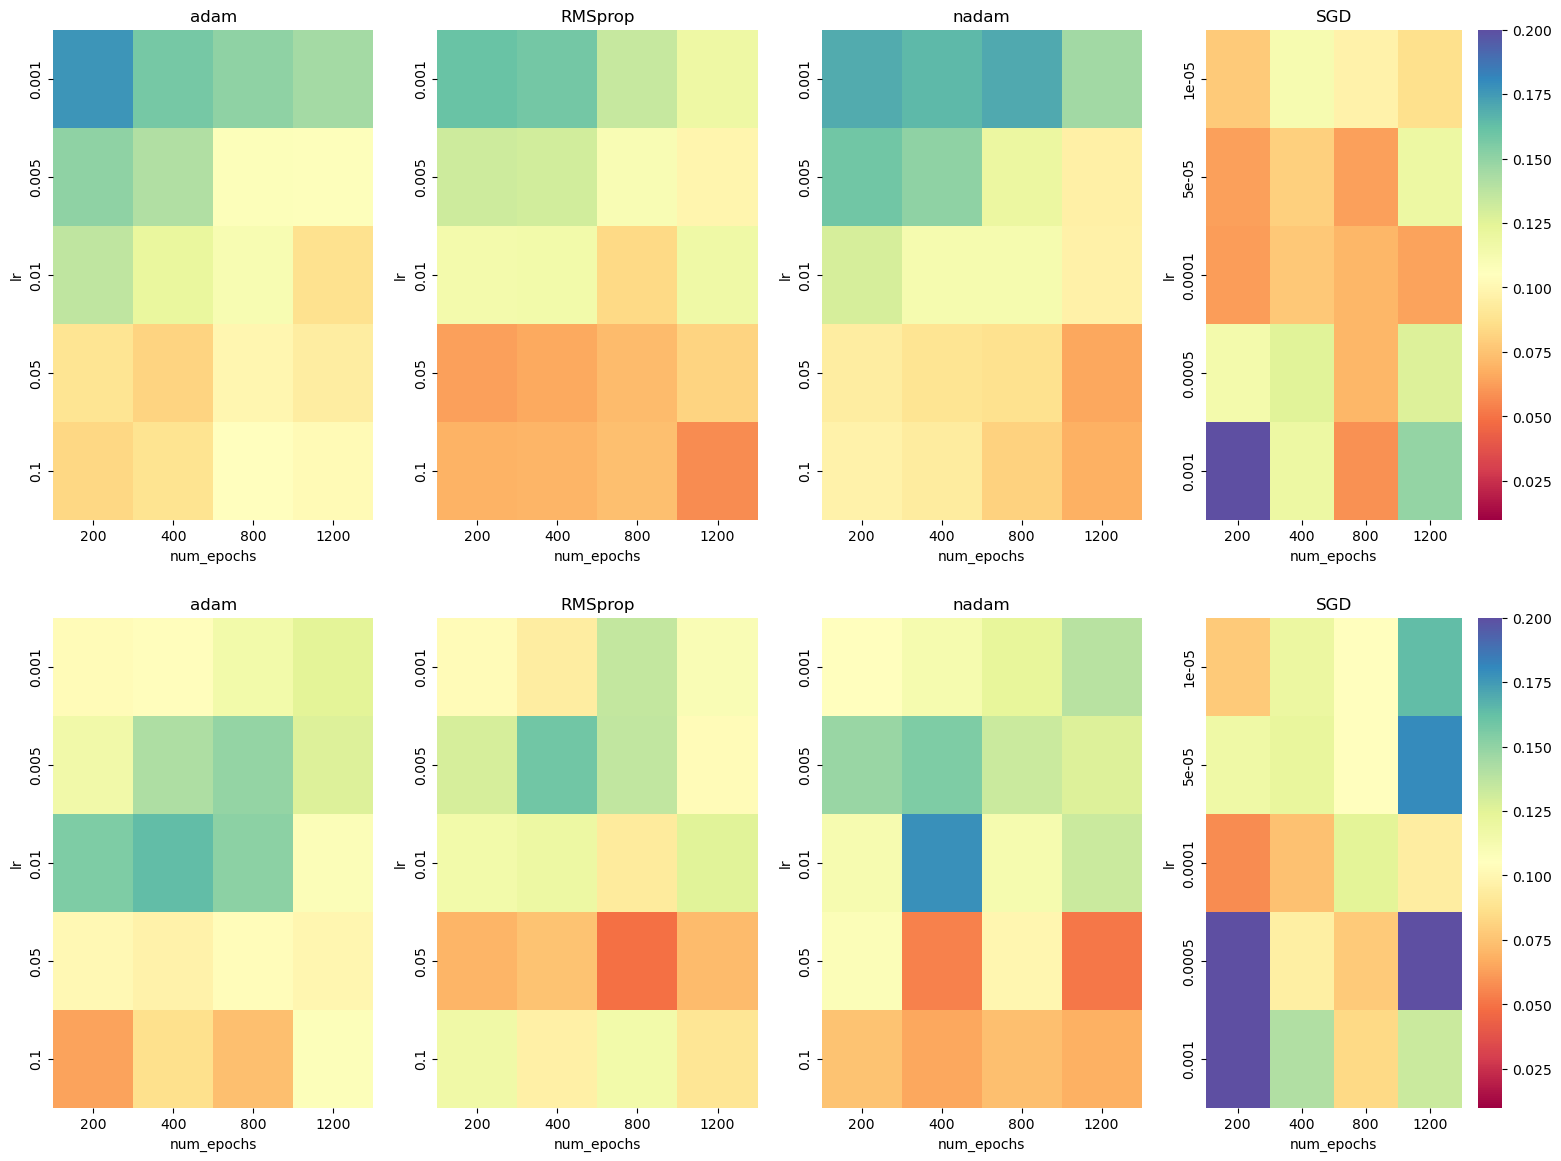

In [98]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (19, 14))

print("scale 10")

for j, opt in enumerate(["adam", "RMSprop", "nadam", "SGD"]):
    for i, sign in enumerate(["plus", "minus"]):
        sns.heatmap(simulations_df.query("(X0_lr_scale == 10)&(optimizer_name == @opt)").groupby(["lr", "num_epochs"]).mean()[f"distance_epsilon_{sign}"].unstack(),
                    cmap = "Spectral", vmin = 0.01, vmax = 0.2, ax = axes[i,j], cbar = opt == "SGD")
        axes[i,j].set_title(f"{opt}")


scale 20


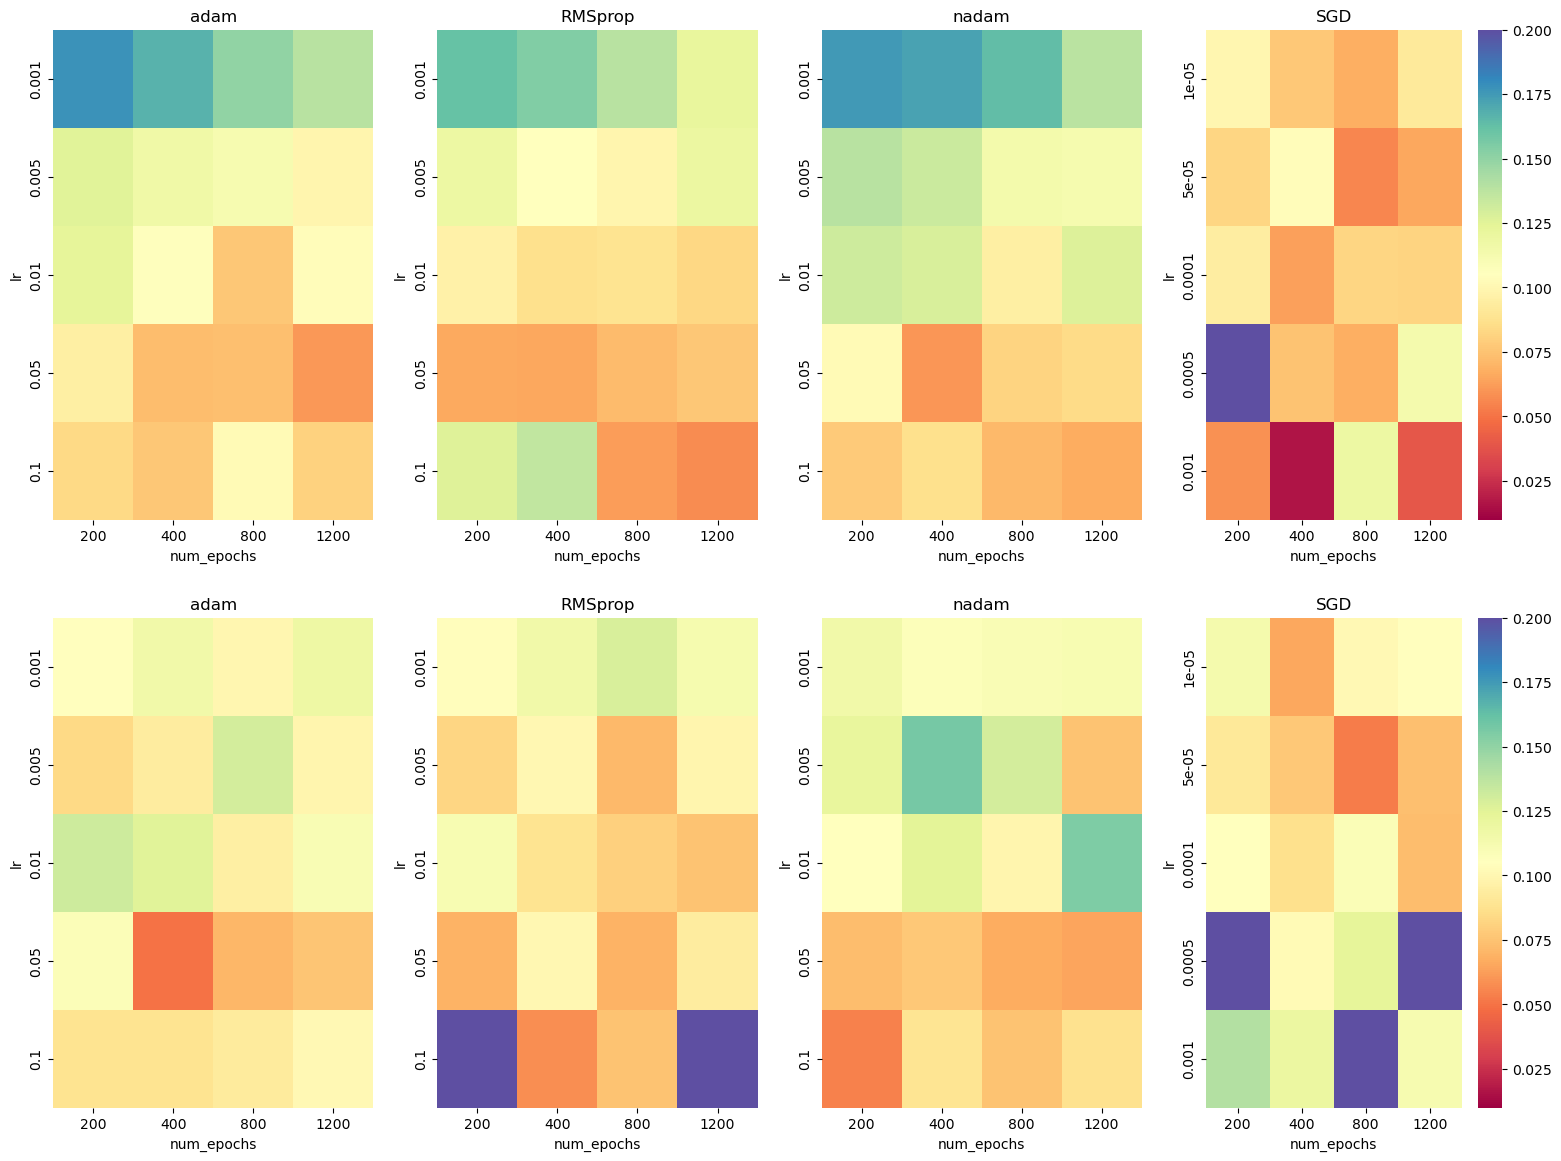

In [100]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (19, 14))

print("scale 20")

for j, opt in enumerate(["adam", "RMSprop", "nadam", "SGD"]):
    for i, sign in enumerate(["plus", "minus"]):
        sns.heatmap(simulations_df.query("(X0_lr_scale == 20)&(optimizer_name == @opt)").groupby(["lr", "num_epochs"]).mean()[f"distance_epsilon_{sign}"].unstack(),
                    cmap = "Spectral", vmin = 0.01, vmax = 0.2, ax = axes[i,j], cbar = opt == "SGD")
        axes[i,j].set_title(f"{opt}")


## X0_r2 varying scale

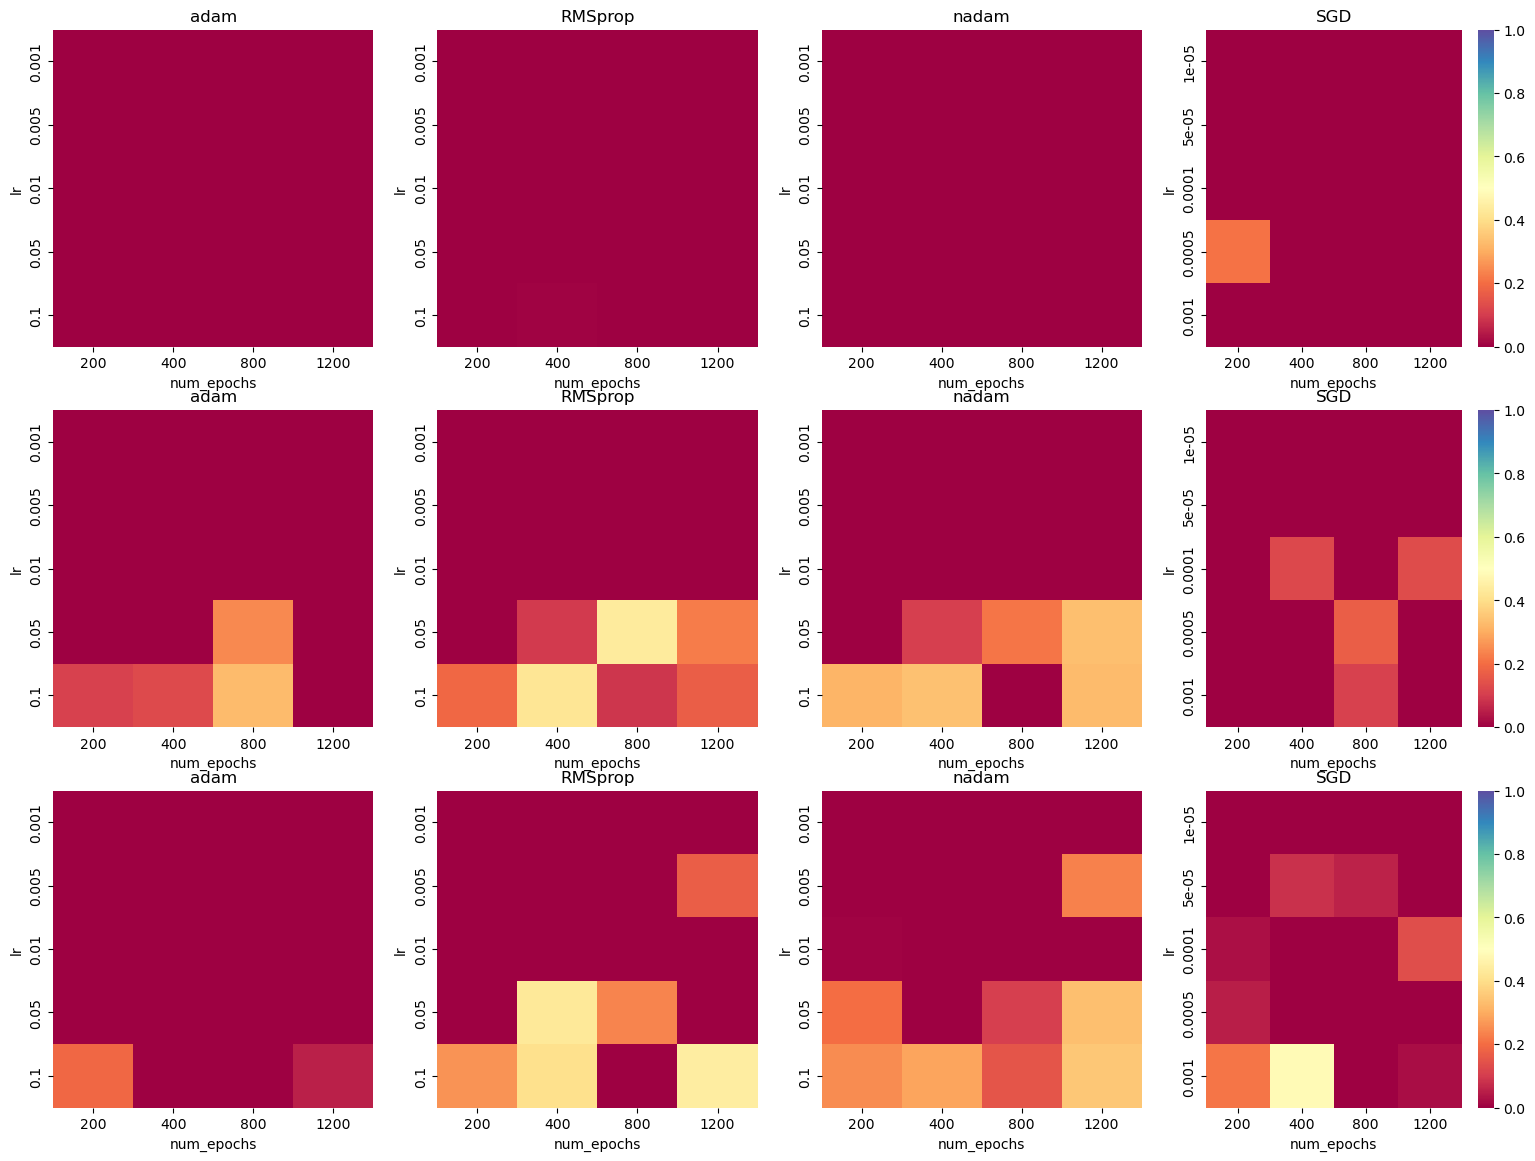

In [104]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize = (19, 14))


for j, opt in enumerate(["adam", "RMSprop", "nadam", "SGD"]):
    for i, scale in enumerate([1,10,20]):
        sns.heatmap(simulations_df.query("(X0_lr_scale == @scale)&(optimizer_name == @opt)").groupby(["lr", "num_epochs"]).mean()["X0_r2"].unstack(),
                    cmap = "Spectral", vmin = 0., vmax = 1., ax = axes[i,j], cbar = opt == "SGD")
        axes[i,j].set_title(f"{opt}")


scale 10


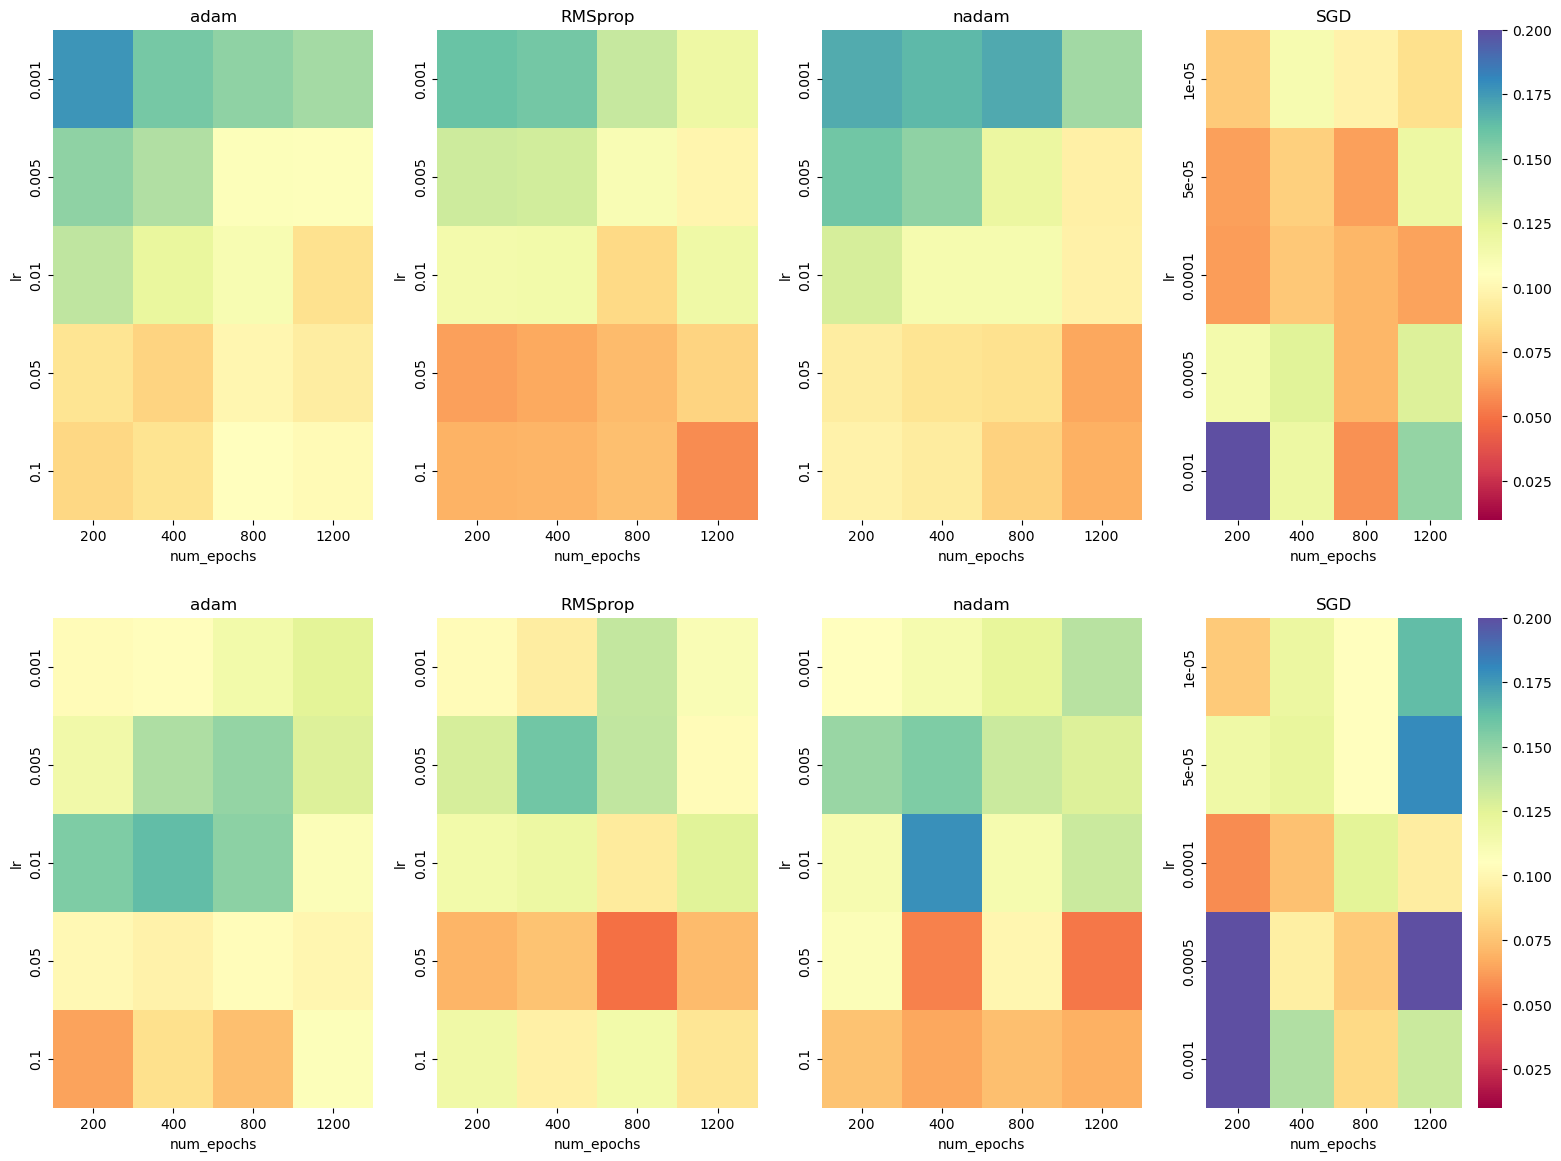

In [98]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (19, 14))

print("scale 10")

for j, opt in enumerate(["adam", "RMSprop", "nadam", "SGD"]):
    for i, sign in enumerate(["plus", "minus"]):
        sns.heatmap(simulations_df.query("(X0_lr_scale == 10)&(optimizer_name == @opt)").groupby(["lr", "num_epochs"]).mean()[f"distance_epsilon_{sign}"].unstack(),
                    cmap = "Spectral", vmin = 0.01, vmax = 0.2, ax = axes[i,j], cbar = opt == "SGD")
        axes[i,j].set_title(f"{opt}")


scale 20


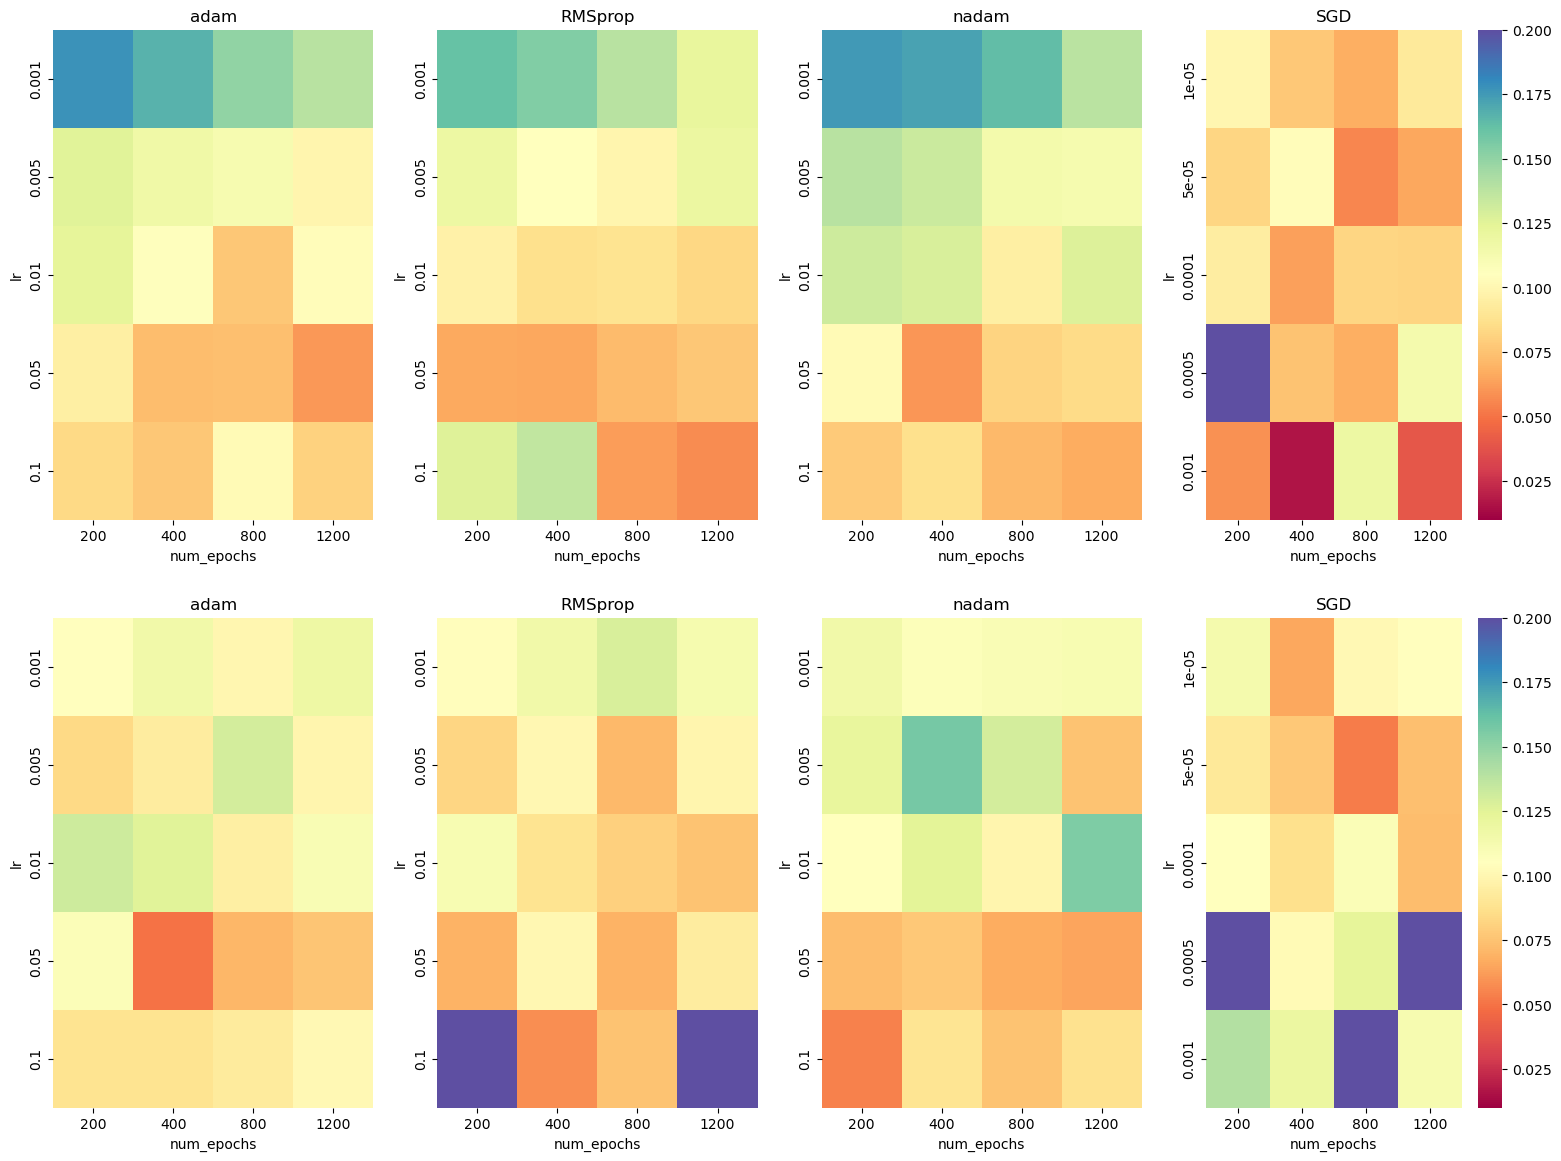

In [100]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (19, 14))

print("scale 20")

for j, opt in enumerate(["adam", "RMSprop", "nadam", "SGD"]):
    for i, sign in enumerate(["plus", "minus"]):
        sns.heatmap(simulations_df.query("(X0_lr_scale == 20)&(optimizer_name == @opt)").groupby(["lr", "num_epochs"]).mean()[f"distance_epsilon_{sign}"].unstack(),
                    cmap = "Spectral", vmin = 0.01, vmax = 0.2, ax = axes[i,j], cbar = opt == "SGD")
        axes[i,j].set_title(f"{opt}")


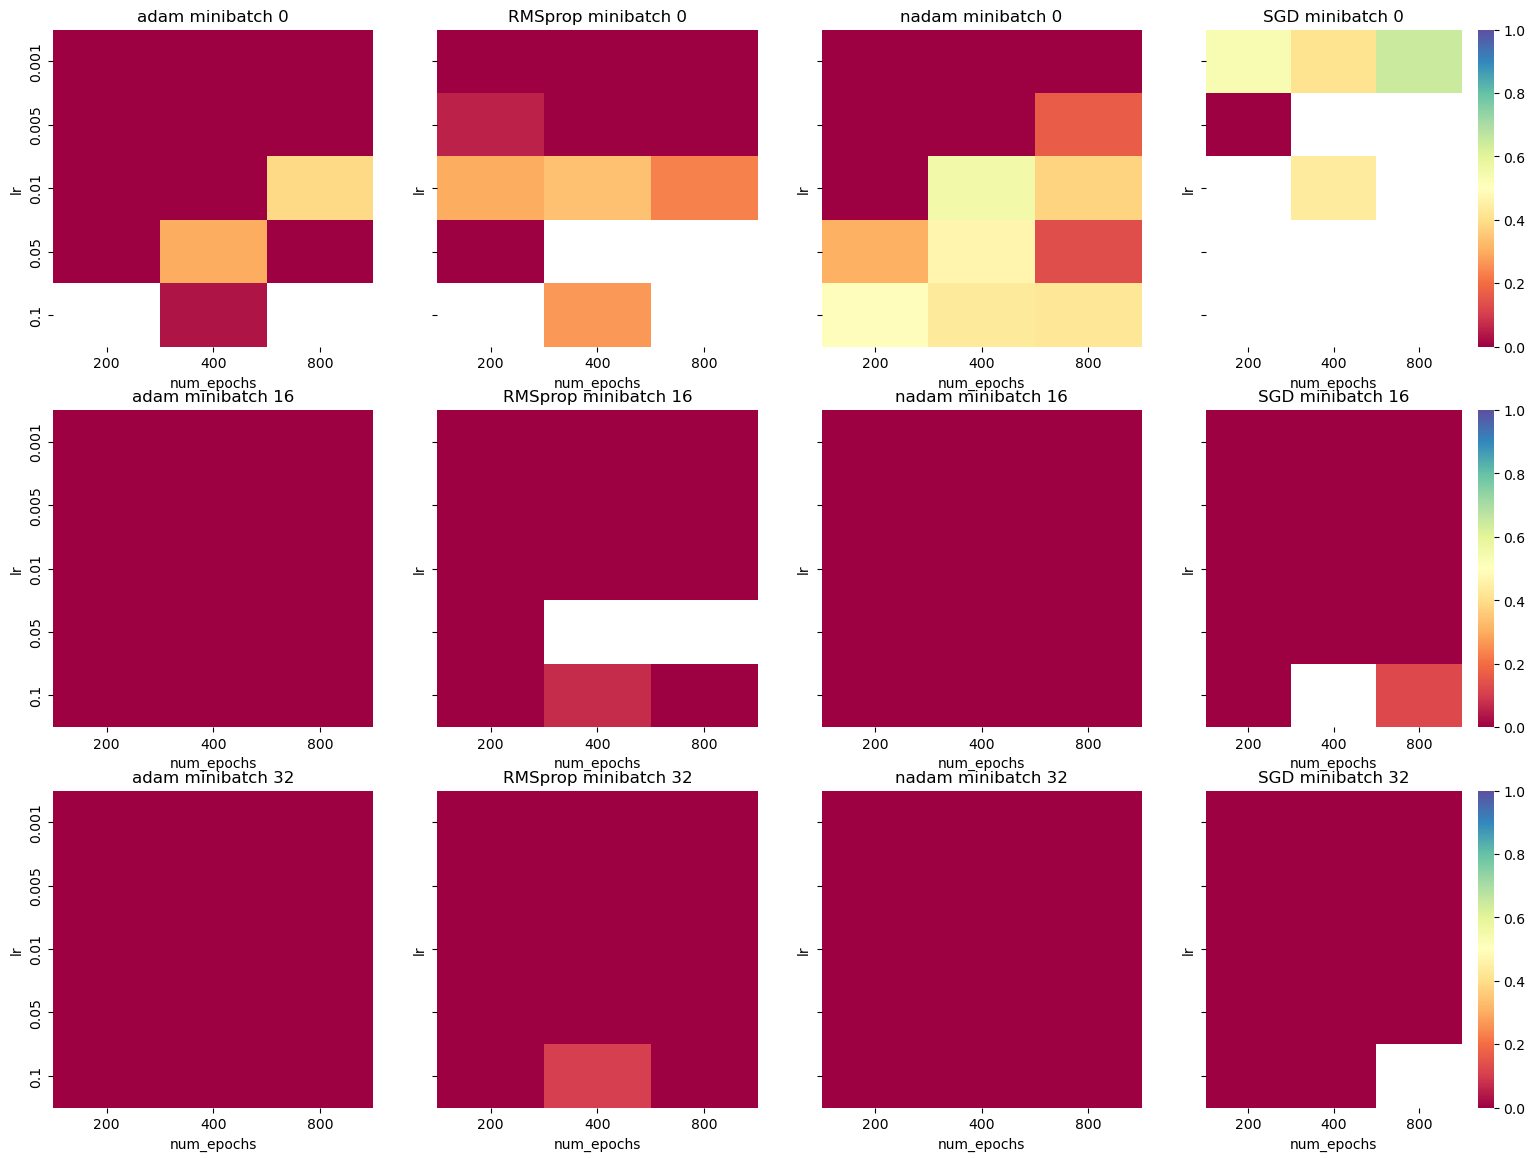

In [206]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize = (19, 14), sharey = True)

for j, opt in enumerate(["adam", "RMSprop", "nadam", "SGD"]):
    for i, minibatch in enumerate([0, 16, 32]):
        sns.heatmap(simulations_df.query("(epsilon_plus_estimated < epsilon_minus_estimated)&(X0_lr_scale == 40)&(minibatch_size == @minibatch)&(optimizer_name == @opt)").groupby(["lr", "num_epochs"]).mean()["X0_r2"].unstack(),
                    cmap = "Spectral", vmin = 0., vmax = 1., ax = axes[i,j], cbar = opt == "SGD")
        axes[i,j].set_title(f"{opt} minibatch {minibatch}")

In [115]:
simulations_df.query("(optimizer_name == 'RMSprop')&(lr == 0.05)&(X0_lr_scale > 1)&(num_epochs < 1000)&(num_epochs > 300)")\
[["optimizer_name", "lr", "num_epochs", "X0_lr_scale", "real_epsilon_plus", "real_epsilon_minus", 
  "mu_plus", "mu_minus", "epsilon_plus_estimated", "epsilon_minus_estimated",
  "distance_epsilon_plus", "distance_epsilon_minus", "X0_r2"]].sort_values(["num_epochs", "X0_lr_scale", "X0_r2"])#\
#.groupby(["optimizer_name", "lr", "num_epochs", "X0_lr_scale"]).mean()


,optimizer_name,lr,num_epochs,X0_lr_scale,real_epsilon_plus,real_epsilon_minus,mu_plus,mu_minus,epsilon_plus_estimated,epsilon_minus_estimated,distance_epsilon_plus,distance_epsilon_minus,X0_r2
325,RMSprop,0.05,400,10,0.042130,0.546906,0.205833,0.433455,0.179391,0.482850,0.137261,0.064057,-1.531162
1285,RMSprop,0.05,400,10,0.805234,0.922741,0.193885,0.246397,0.793551,0.923394,0.011683,0.000652,-0.629541
1045,RMSprop,0.05,400,10,0.509240,0.625706,0.064227,0.485210,0.414132,0.496482,0.095108,0.129225,0.101125
805,RMSprop,0.05,400,10,0.313992,0.715225,0.007136,0.469560,0.314689,0.667854,0.000698,0.047371,0.364644
1525,RMSprop,0.05,400,10,0.001914,0.851646,0.113554,0.442886,0.070334,0.901489,0.068421,0.049843,0.486081
1765,RMSprop,0.05,400,10,0.404232,0.807824,0.066590,0.423946,0.312768,0.711111,0.091465,0.096713,0.502146
85,RMSprop,0.05,400,10,0.301033,0.542646,0.289772,0.006416,0.424383,0.721742,0.123350,0.179095,0.672509
565,RMSprop,0.05,400,10,0.224827,0.724244,0.269708,0.256508,0.226593,0.759403,0.001767,0.035158,0.803520
1286,RMSprop,0.05,400,20,0.805234,0.922741,0.193885,0.246397,0.769315,0.980061,0.035918,0.057320,-0.533893
326,RMSprop,0.05,400,20,0.042130,0.546906,0.205833,0.433455,0.142307,0.728435,0.100177,0.181529,0.368069


In [163]:
simulations_df.query("(num_epochs == 800)&(optimizer_name == 'nadam')&(minibatch_size == 0)&(X0_lr_scale == 10)&(lr == 0.1)").drop(["N", "T", "edge_per_t", "evidences_per_t", "model", "model_name", "last_iteration"], axis = 1)


,optimizer_name,num_epochs,lr,minibatch_size,X0_lr_scale,epsilon_plus_estimated,epsilon_minus_estimated,X0_r2,time,real_epsilon_plus,real_epsilon_minus,mu_plus,mu_minus,rho,distance_epsilon_plus,distance_epsilon_minus
396,nadam,800,0.1,0,10,0.454833,0.465403,0.446102,38.649347,0.395232,0.407510,0.414249,0.390880,16,0.059600,0.057893
936,nadam,800,0.1,0,10,0.426925,0.422509,0.569608,82.256552,0.420055,0.452894,0.008124,0.186875,16,0.006870,0.030385
1476,nadam,800,0.1,0,10,0.406141,0.278479,0.034463,82.944624,0.115842,0.167060,0.147622,0.427711,16,0.290299,0.111419
2016,nadam,800,0.1,0,10,0.175372,0.560502,0.298229,38.119354,0.019909,0.421074,0.393360,0.194774,16,0.155463,0.139427
2556,nadam,800,0.1,0,10,0.291912,0.055204,-0.011574,38.159252,0.031193,0.070564,0.300127,0.268944,16,0.260718,0.015360
3096,nadam,800,0.1,0,10,0.326709,0.226777,0.389091,83.057805,0.131909,0.189425,0.123505,0.394358,16,0.194800,0.037352
3636,nadam,800,0.1,0,10,0.240390,0.227198,0.490641,40.833741,0.166340,0.272758,0.262435,0.165279,16,0.074050,0.045560
4176,nadam,800,0.1,0,10,0.312277,0.453594,0.361041,87.301165,0.261696,0.488707,0.319098,0.452497,16,0.050582,0.035113
